# Import

In [1]:
from joblib import Parallel, delayed
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 
from os import path
import pandas as pd 
import os
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
import datetime
import math
import time
import pickle
import random
from scipy.spatial import cKDTree
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sys
from sklearn.metrics import r2_score as r2
#from rdkit import Chem
from sklearn.decomposition import PCA
import rishi_utils as ru

import importlib
import efrc_ml_production as ml
importlib.reload(ml)
importlib.reload(ru)
from skopt import gp_minimize

from multiprocessing import Pool

/home/modules/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/modules/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.model_selection import LeaveOneOut,KFold

# New

In [6]:
class hmofMLdataset:
    def __init__(self, results_dir, now, SI_grav_data_path='/data/rgur/efrc/prep_data/all_v1/ml_data.csv', 
                 SD_grav_data_path='/data/rgur/efrc/prep_data/all_no_norm/ml_data.csv',SI_stacked_path=
                '/data/rgur/efrc/prep_data/all_v1/stacked.csv',
                 SD_stacked_path='/data/rgur/efrc/prep_data/all_no_norm/stacked.csv',
                 Y_DATA_PATH='/data/rgur/efrc/data_DONOTTOUCH/hMOF_allData_March25_2013.xlsx', n_core=15, skip=None, 
                 do=None, nn_space=None, grav_algo='xgb'):
        self.results_dir = results_dir 
        os.chdir(self.results_dir)
        self.SI_grav_data_path = SI_grav_data_path
        self.SD_grav_data_path = SD_grav_data_path
        self.SI_stacked_path = SI_stacked_path
        self.SD_stacked_path = SD_stacked_path
        self.n_core = n_core
        self.Y_DATA_PATH = Y_DATA_PATH
        self.del_defective_mofs = False
        self.cat_si_sd = True
        self.add_size_fp = True #make True if you want to add 20 feature columns, where each feature is the number of atoms in a linker
        self.srt_size_fp = True
        self.iso_start_str_sd = 'Density'
        self.iso_end_str_sd = 'norm_Dom._Pore_(ang.)'
        self.grav_start_str_sd = 'CH4_v/v_248_bar'
        self.grav_end_str_sd = 'norm_Dom._Pore_(ang.)'
        self.start_str_si = 'filename'
        self.end_str_si = 'valence_pa'
        self.cat_col_names = ['cat_1', 'cat_2', 'cat_3', 'cat_4']
        self.skip = skip
        self.feature_codes = ['10000', '11000', '01000', '10100', '11100', '01100',
                             '10010', '11010', '01010', '10110', '11110', '01110',
                             '10001', '11001', '01001', '10101', '11101', '01101',
                             '10011', '11011', '01011', '10111', '11111', '01111']
        self.do = do
        if self.do != None:
            self.feature_codes = self.do
        elif skip != None:
            self.feature_codes = [i for i in self.feature_codes if i not in self.skip]   
        print("There are %s unique feature codes" %len(set(self.feature_codes)))
        self.any_stacked = any([item[-1]=='1' for item in self.feature_codes]) #are any codes for stacked models?
        self.now = now
        print("now is %s" %self.now)
        self.nn_space = nn_space
        self.grav_algo = grav_algo
    def makeMasterDFs(self):
        #gravimetric
        self.grav, self.grav_prop, self.grav_target_mean, self.grav_target_std, self.grav_all_features = \
                                            ml.prepToSplit(
                                            self.grav_algo, self.cat_si_sd, self.SD_grav_data_path, self.SI_grav_data_path, 
                                            self.grav_start_str_sd, self.grav_end_str_sd, self.start_str_si, 
                                            self.end_str_si, 1, self.del_defective_mofs, self.add_size_fp, 
                                            self.srt_size_fp, None, stacked=False, n_core=self.n_core, 
                                            del_geometric_fp=False, cat_col_names=self.cat_col_names, 
                                            Y_DATA_PATH=self.Y_DATA_PATH
                                            )
        size_cols = ["size_%s" %s for s in range(20)]
        self.LS_dict = {row[1]['filename']:row[1][size_cols] for row in self.grav.iterrows()} # map from filename 
                                                                                        #to linkersize-vector
        #stacked
        if self.any_stacked:
            self.iso, self.iso_prop, self.iso_target_mean, self.iso_target_std, self.iso_all_features, self.pinfo = \
                                                ml.prepToSplit(
                                                'nn', self.cat_si_sd, self.SD_stacked_path, self.SI_stacked_path, 
                                                self.iso_start_str_sd, self.iso_end_str_sd, self.start_str_si, 
                                                self.end_str_si, 1, self.del_defective_mofs, self.add_size_fp, 
                                                self.srt_size_fp, None, True, self.n_core, False, self.cat_col_names, 
                                                self.Y_DATA_PATH, self.LS_dict) 
    def select_features(self, code, stacked):
        '''
        Should only be called after makeMasterDFs
        '''
        si = bool(int(code[0])) #True (=1) if size-independent features are included
        sd = bool(int(code[1])) #True (=1) if size-dependent features are included
        size_fp = bool(int(code[2])) #True (=1) if linker size features are included
        geo_fp = bool(int(code[3])) #True (=1) if geometric features are included
        non_pg = ml.getNonPGcolNames(size_fp, stacked, not geo_fp, self.cat_col_names)
        pg = []
        if si:
            try:
                si_df = pd.read_csv(self.SI_grav_data_path)
            except:
                si_df = pd.read_csv(self.SI_grav_data_path, compression='gzip')
            self.all_pg = [s for s in ml.getPGcolNames(si_df, start_str=self.start_str_si, end_str=self.end_str_si)]
            pg += [s+'_si' for s in ml.getPGcolNames(si_df, start_str=self.start_str_si, end_str=self.end_str_si) 
                   if s+'_si' in self.grav_all_features]
            del si_df
        if sd:
            try:
                sd_df = pd.read_csv(self.SD_grav_data_path)
            except:
                sd_df = pd.read_csv(self.SD_grav_data_path, compression='gzip')
            pg += [s for s in ml.getPGcolNames(sd_df, self.grav_start_str_sd, self.grav_end_str_sd) if s in
                  self.grav_all_features]
        return non_pg + pg
    def makeAllResults(self):
        self.makeMasterDFs()
        print('\n')
        #Parallel(n_jobs=self.n_core)(delayed(self.makeResult)(j) for j in self.feature_codes)
        for i in self.feature_codes: #True if stacked
                STACKED = bool(int(i[-1])) #True (=1) if stacked
                CODE = i[:-1]
                run_features = self.select_features(code=CODE, stacked=STACKED)
                if STACKED:
                    print("Running code %s for isotherm model" %CODE)
                    drop_features = [s for s in self.iso_all_features if s not in run_features]
                    algo = 'nn'
                else:
                    print("Running code %s for gravimetric uptake model" %CODE)
                    algo = self.grav_algo
                    drop_features = [s for s in self.grav_all_features if s not in run_features]
                    #l.append(self.iso.drop(drop_features, axis=1))
                if algo == 'nn':
                    N_CORE=1
                else:
                    N_CORE=self.n_core
                if STACKED:
                    FpDataSet(self.iso.drop(drop_features, axis=1), run_features, self.iso_prop, 
                              self.iso_target_mean, self.iso_target_std, now=self.now, nn_space=self.nn_space, 
                              stacked=STACKED, fp_code=CODE, n_core=N_CORE, grav_algo=self.grav_algo).train()
                else:
                    FpDataSet(self.grav.drop(drop_features, axis=1), run_features, self.grav_prop, 
                              self.grav_target_mean, self.grav_target_std, now=self.now, nn_space=self.nn_space,
                              stacked=STACKED, fp_code=CODE, n_core=N_CORE, grav_algo=self.grav_algo).train()
class FpDataSet:
    def __init__(self, df, features, property_used, target_mean, target_std, stacked, now, nn_space, fp_code='0', 
                    n_core=15, grav_algo='xgb', track=True, chkpt_name='model_checkpoint',n_folds=15):
        self.n_folds = n_folds #for master run
        self.now = now
        self.df = df
        self.fp_code = fp_code
        self.property_used = property_used
        self.target_mean = target_mean
        self.target_std = target_std
        self.n_samples = len(self.df)
        self.features = features
        self.stacked = stacked
        self.n_core = n_core
        self.grav_algo = grav_algo
        self.track=track
        self.chkpt_name = chkpt_name
        self.file_tracker = {'train':[],'test':[]}
        self.pressure_tracker = {'train':[],'test':[]}
        if self.stacked:
            self.algo = 'nn'
            self.model_tag = 'iso'
        else:
            self.algo = self.grav_algo
            self.model_tag = 'grav'
        self.nn_space = nn_space
        self.hp_frac = .05
        self.fn = self.df['filename'].unique() #filenames
        
    def make_splits(self):
        def gen():
            for train_index, test_index in KFold(self.n_folds).split(self.fn):
                train_fn = self.fn[train_index]
                test_fn = self.fn[test_index]
                train_df = self.df[self.df['filename'].isin(train_fn)].reset_index().drop('index', axis=1)
                test_df = self.df[self.df['filename'].isin(test_fn)].reset_index().drop('index', axis=1)
                if self.track:
                    self.file_tracker['train'].append(train_df['filename'].tolist())
                    self.file_tracker['test'].append(test_df['filename'].tolist())
                    try:
                        self.pressure_tracker['train'].append(train_df['pressure'].tolist())
                        self.pressure_tracker['test'].append(test_df['pressure'].tolist())
                    except:
                        self.pressure_tracker['train'].append(['na']*len(train_df))
                        self.pressure_tracker['test'].append(['na']*len(test_df))
                X_train, X_test = train_df[self.features].to_numpy(), test_df[self.features].to_numpy()
                y_train, y_test = train_df[self.property_used].to_numpy(), test_df[self.property_used].to_numpy()
                yield X_train,y_train,X_test,y_test

        return tf.data.Dataset.from_generator(gen, (tf.float32,tf.float32,tf.float32,tf.float32))    
    def CV_objective(self, params):
        try:
            lr = params[1]
        except:
            lr = .001 #default
        try:
            h_units = params[0]
        except:
            h_units = 100 #default
        patience = 15 #default
        try:
            BS = params[2]
        except:
            BS = 32 #default
        dataset = self.make_splits()
        start = time.time()
        import datetime
        rmses = []
        os.system('rm %s.h5' %self.chkpt_name)
        try:
            os.system('rm -rf logs')
        except:
            pass
        fold = 0
        for X_train,y_train,X_test,y_test in dataset:
            early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
            checkpoint_callbacks = keras.callbacks.ModelCheckpoint(filepath='%s.h5' %self.chkpt_name, monitor='val_loss',\
                                                                  verbose=1, save_best_only=True, mode='min')
            model = ml.build_model(X_train.shape[1], lr, h_units, 'relu')

            model.fit(X_train, y_train, batch_size=BS,epochs=1000, verbose=1, 
                      callbacks=[checkpoint_callbacks, early_stop],
                        validation_split=None, validation_data=(X_test,y_test), shuffle=True, class_weight=None,
                        sample_weight=None, initial_epoch=0, steps_per_epoch=None,
                        validation_steps=None, validation_freq=1, max_queue_size=10, workers=1,
                        use_multiprocessing=False
                     ) 
            model.load_weights(filepath='%s.h5' %self.chkpt_name)
            preds = model.predict(X_test).flatten()
            rmse = ml.get_rmse(preds, y_test)
            print("RMSE of fold %s is %s" %( fold,rmse ))
            rmses.append(rmse)
            if self.track:
                n_train = len(self.file_tracker['train'][fold])
                n_test = len(self.file_tracker['test'][fold])
                res_test_predictions, res_test_label, res_train_label, res_train_predictions = \
                    ml.unscale(preds, model.predict(X_train).flatten(), y_test.numpy(), 
                           y_train.numpy(), self.target_mean, self.target_std)
                results_df = pd.DataFrame({"Filename": self.file_tracker['train'][fold]+ \
                                       self.file_tracker['test'][fold], 
                                       "Pressure": self.pressure_tracker['train'][fold]+ \
                                       self.pressure_tracker['test'][fold], 
                                       "Class": ['Train']*n_train+['Test']*n_test,
                                    "Prediction": res_train_predictions.tolist()+res_test_predictions.tolist(),
                                      "Truth": res_train_label.tolist()+res_test_label.tolist()}
                                     )
                save_fragment = '%s_code_%s_fold_%s_%s' %(self.model_tag, self.fp_code, fold, self.now)
                results_df.to_csv('results_%s.csv' %save_fragment, compression='gzip')
                print("Save Results using Fragment %s" %save_fragment)
                try:
                    model.save_model('%s.xgb' %save_fragment)
                except:
                    model.save('%s.h5' %save_fragment,save_format='h5')
            
            fold+=1
        print("\nBest fold is %s" %np.array(rmses).argmax())
        print("Average RMSEs of best epochs in each fold: %s" %np.mean(rmses))
        end = time.time()
        print('Set of Folds Done in %s' %(end-start))        
        if self.track:
            save_fragment = '%s_code_%s_%s' %(self.model_tag, self.fp_code, self.now)
            with open('file_tracker_%s.pkl' %save_fragment, 'wb') as f:
                pickle.dump(self.file_tracker, f)
        return np.mean(rmses)
    def train(self):
        hp_files = np.random.choice(self.fn, size=round(len(self.fn)*self.hp_frac), replace=False)
        hp_df = self.df[self.df['filename'].isin(hp_files)].reset_index().drop('index', axis=1)
        hp_df.to_csv('hp_df.csv', compression='gzip')
        print("Saved hp_df to disk")
        params = HPOpt(hp_df, self.features, self.property_used, self.target_mean, self.target_std, 
                      self.stacked, now=self.now, space=self.nn_space, grav_algo=self.grav_algo).get_params()
        print("Optimzed Hyperparameters found: %s" %params)
        mean_rmse = self.CV_objective(params)

class HPOpt:
    def __init__(self, df, features, property_used, target_mean, target_std, stacked, 
                 space, now, n_trees=50, grav_algo='xgb'):
        self.df = df
        self.space = space
        self.stacked = stacked
        self.property_used = property_used
        self.features = features
        self.target_mean = target_mean
        self.target_std = target_std
        self.n_trees = n_trees
        self.grav_algo = grav_algo
        self.now = now
        if stacked:
            self.N_CALLS = 20
            self.algo = 'nn'
        else:
            self.N_CALLS = 30
            self.algo = self.grav_algo
        
        print("Using %s calls for HPOpt" %self.N_CALLS)
    def get_params(self):
        HP_Inst = FpDataSet(self.df, self.features, self.property_used, self.target_mean, self.target_std, 
                            self.stacked, self.now, self.space, '0',1, self.grav_algo, track=False, 
                            chkpt_name='hp_model_checkpoint', n_folds=5)
        self.start = time.time()
        r = gp_minimize(HP_Inst.CV_objective, self.space, n_calls=self.N_CALLS)
        self.end = time.time()
        print("Finished HPOpt in %s" %(self.end-self.start))
        self.params = r.x
        return self.params

# Try

In [7]:
start = time.time()

PATH = '/data/rgur/efrc/paper_data/isotherm_models/test'

now = datetime.datetime.now().strftime("%I_%M%p_on_%B_%d_%Y")

Y_DATA_PATH = '/data/rgur/efrc/data_DONOTTOUCH/hMOF_allData_March25_2013.xlsx'

NN_SPACE = [(250, 600), #n_units
                (.0002, .001),#learning rate
                (8, 512)] #batch size
GRAV_ALGO = 'nn'
DO = ['10111']
out = hmofMLdataset(PATH, now, Y_DATA_PATH=Y_DATA_PATH,
                   SI_grav_data_path='/data/rgur/efrc/prep_data/all_v1/ml_data_head.csv',
                 SD_grav_data_path='/data/rgur/efrc/prep_data/all_no_norm/ml_data_head.csv',
                   SI_stacked_path='/data/rgur/efrc/prep_data/all_v1/stacked_head.csv',
                 SD_stacked_path='/data/rgur/efrc/prep_data/all_no_norm/stacked_head.csv',
             do=DO, nn_space=NN_SPACE).makeAllResults()

end = time.time()

print("Whole thing done in %s" %( end-start ) )

There are 1 unique feature codes
now is 12_04PM_on_May_09_2020

Starting to Construct Gravimetric Uptake Data Frame
Using start_str_sd CH4_v/v_248_bar
Using end_str_sd norm_Dom._Pore_(ang.)
Using start_str_si filename
Using end_str_si valence_pa
Total frac equals 1


Starting To Make Linker Size Columns
Starting to sort Linker Size Columns
Finished Making Linker Size Columns
The following columns have been dropped: ['norm_Mafp_C1_N2_N3', 'norm_Mafp_N2_O2_N3', 'norm_Mmfp_MQNs22', 'norm_Mmfp_MQNs23', 'norm_Mmfp_MQNs24', 'norm_Mmfp_MQNs25']

Starting to Construct Isotherm Stacked Data Frame
Using start_str_sd Density
Using end_str_sd norm_Dom._Pore_(ang.)
Using start_str_si filename
Using end_str_si valence_pa
Total frac equals 1


Starting To Make Linker Size Columns
Finished Making Linker Size Columns
The following columns have been dropped: ['norm_Mafp_C1_N2_N3', 'norm_Mafp_N2_O2_N3', 'norm_Mmfp_MQNs22', 'norm_Mmfp_MQNs23', 'norm_Mmfp_MQNs24', 'norm_Mmfp_MQNs25']


Running code 1011 fo

Epoch 3/1000

Epoch 00003: val_loss improved from 0.62843 to 0.45904, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1575 - mae: 0.3608 - mse: 0.1575 - val_loss: 0.4590 - val_mae: 0.6017 - val_mse: 0.4590
Epoch 4/1000

Epoch 00004: val_loss improved from 0.45904 to 0.31142, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0494 - mae: 0.1860 - mse: 0.0494 - val_loss: 0.3114 - val_mae: 0.4005 - val_mse: 0.3114
Epoch 5/1000

Epoch 00005: val_loss improved from 0.31142 to 0.24735, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0694 - mae: 0.2228 - mse: 0.0694 - val_loss: 0.2473 - val_mae: 0.4665 - val_mse: 0.2473
Epoch 6/1000

Epoch 00006: val_loss improved from 0.24735 to 0.24586, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0843 - mae: 0.2627 - mse: 0.0843 - val_loss: 0.2

Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.19473
8/8 [==============================] - 0s 2ms/sample - loss: 0.0067 - mae: 0.0557 - mse: 0.0067 - val_loss: 0.2304 - val_mae: 0.4800 - val_mse: 0.2304
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.19473
8/8 [==============================] - 0s 2ms/sample - loss: 0.0049 - mae: 0.0564 - mse: 0.0049 - val_loss: 0.2438 - val_mae: 0.4911 - val_mse: 0.2438
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.19473
8/8 [==============================] - 0s 2ms/sample - loss: 0.0087 - mae: 0.0663 - mse: 0.0087 - val_loss: 0.2575 - val_mae: 0.5014 - val_mse: 0.2575
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.19473
8/8 [==============================] - 0s 2ms/sample - loss: 0.0116 - mae: 0.0918 - mse: 0.0116 - val_loss: 0.2665 - val_mae: 0.5100 - val_mse: 0.2665
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.19473
8/8 [==============================] - 0s 2ms/sample - loss: 0.010

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00794
8/8 [==============================] - 0s 2ms/sample - loss: 0.0242 - mae: 0.1091 - mse: 0.0242 - val_loss: 0.0920 - val_mae: 0.2980 - val_mse: 0.0920
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00794
8/8 [==============================] - 0s 2ms/sample - loss: 0.0335 - mae: 0.1286 - mse: 0.0335 - val_loss: 0.0820 - val_mae: 0.2816 - val_mse: 0.0820
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00794
8/8 [==============================] - 0s 2ms/sample - loss: 0.0312 - mae: 0.1281 - mse: 0.0312 - val_loss: 0.0521 - val_mae: 0.2235 - val_mse: 0.0521
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00794
8/8 [==============================] - 0s 2ms/sample - loss: 0.0222 - mae: 0.1176 - mse: 0.0222 - val_loss: 0.0232 - val_mae: 0.1461 - val_mse: 0.0232
Epoch 15/1000

Epoch 00015: val_loss improved from 0.00794 to 0.00566, saving model to hp_model_checkpoint.h5
8/8 [=================

Epoch 48/1000

Epoch 00048: val_loss did not improve from 0.00122
8/8 [==============================] - 0s 3ms/sample - loss: 4.6384e-04 - mae: 0.0158 - mse: 4.6384e-04 - val_loss: 0.0029 - val_mae: 0.0455 - val_mse: 0.0029
Epoch 49/1000

Epoch 00049: val_loss did not improve from 0.00122
8/8 [==============================] - 0s 2ms/sample - loss: 1.7397e-04 - mae: 0.0100 - mse: 1.7397e-04 - val_loss: 0.0040 - val_mae: 0.0565 - val_mse: 0.0040
RMSE of fold 4 is 0.03499061254754253

Best fold is 3
Average RMSEs of best epochs in each fold: 0.40556310884185276
Set of Folds Done in 5.621715307235718
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.84524, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 50ms/sample - loss: 0.9739 - mae: 0.9199 - mse: 0.9739 - val_loss: 0.8452 - val_mae: 0.9173 - val_mse: 0.8452
Epoch 2/1000

Epoch 00002: val_loss improved from 0.84524 to 0.82221, saving model to hp_model_

8/8 [==============================] - 0s 4ms/sample - loss: 0.0036 - mae: 0.0518 - mse: 0.0036 - val_loss: 0.1522 - val_mae: 0.3824 - val_mse: 0.1522
Epoch 31/1000

Epoch 00031: val_loss improved from 0.15219 to 0.15080, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0022 - mae: 0.0386 - mse: 0.0022 - val_loss: 0.1508 - val_mae: 0.3803 - val_mse: 0.1508
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.15080
8/8 [==============================] - 0s 1ms/sample - loss: 0.0018 - mae: 0.0332 - mse: 0.0018 - val_loss: 0.1513 - val_mae: 0.3807 - val_mse: 0.1513
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.15080
8/8 [==============================] - 0s 1ms/sample - loss: 0.0021 - mae: 0.0372 - mse: 0.0021 - val_loss: 0.1539 - val_mae: 0.3839 - val_mse: 0.1539
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.15080
8/8 [==============================] - 0s 1ms/sample - loss: 0.0026 - mae: 0.0434 - mse:

8/8 [==============================] - 0s 4ms/sample - loss: 0.0383 - mae: 0.1787 - mse: 0.0383 - val_loss: 0.2343 - val_mae: 0.4220 - val_mse: 0.2343
Epoch 19/1000

Epoch 00019: val_loss improved from 0.23427 to 0.22932, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0301 - mae: 0.1531 - mse: 0.0301 - val_loss: 0.2293 - val_mae: 0.4199 - val_mse: 0.2293
Epoch 20/1000

Epoch 00020: val_loss improved from 0.22932 to 0.22523, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0212 - mae: 0.1278 - mse: 0.0212 - val_loss: 0.2252 - val_mae: 0.4148 - val_mse: 0.2252
Epoch 21/1000

Epoch 00021: val_loss improved from 0.22523 to 0.22191, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0135 - mae: 0.1026 - mse: 0.0135 - val_loss: 0.2219 - val_mae: 0.4078 - val_mse: 0.2219
Epoch 22/1000

Epoch 00022: val_loss improved from 0.22191 to 0.22

Epoch 54/1000

Epoch 00054: val_loss did not improve from 0.21480
8/8 [==============================] - 0s 2ms/sample - loss: 3.8380e-04 - mae: 0.0158 - mse: 3.8380e-04 - val_loss: 0.2282 - val_mae: 0.3857 - val_mse: 0.2282
Epoch 55/1000

Epoch 00055: val_loss did not improve from 0.21480
8/8 [==============================] - 0s 2ms/sample - loss: 2.9208e-04 - mae: 0.0141 - mse: 2.9208e-04 - val_loss: 0.2282 - val_mae: 0.3880 - val_mse: 0.2282
Epoch 56/1000

Epoch 00056: val_loss did not improve from 0.21480
8/8 [==============================] - 0s 2ms/sample - loss: 2.6238e-04 - mae: 0.0137 - mse: 2.6238e-04 - val_loss: 0.2281 - val_mae: 0.3899 - val_mse: 0.2281
Epoch 57/1000

Epoch 00057: val_loss did not improve from 0.21480
8/8 [==============================] - 0s 1ms/sample - loss: 2.8058e-04 - mae: 0.0143 - mse: 2.8058e-04 - val_loss: 0.2277 - val_mae: 0.3914 - val_mse: 0.2277
RMSE of fold 1 is 0.4634690031326546
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 0

8/8 [==============================] - 0s 5ms/sample - loss: 0.0073 - mae: 0.0685 - mse: 0.0073 - val_loss: 0.0918 - val_mae: 0.2885 - val_mse: 0.0918
Epoch 31/1000

Epoch 00031: val_loss improved from 0.09178 to 0.09113, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0065 - mae: 0.0643 - mse: 0.0065 - val_loss: 0.0911 - val_mae: 0.2900 - val_mse: 0.0911
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.09113
8/8 [==============================] - 0s 1ms/sample - loss: 0.0056 - mae: 0.0624 - mse: 0.0056 - val_loss: 0.0915 - val_mae: 0.2931 - val_mse: 0.0915
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.09113
8/8 [==============================] - 0s 1ms/sample - loss: 0.0046 - mae: 0.0576 - mse: 0.0046 - val_loss: 0.0929 - val_mae: 0.2978 - val_mse: 0.0929
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.09113
8/8 [==============================] - 0s 2ms/sample - loss: 0.0035 - mae: 0.0519 - mse:

Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.79396
8/8 [==============================] - 0s 2ms/sample - loss: 0.0119 - mae: 0.0976 - mse: 0.0119 - val_loss: 0.8764 - val_mae: 0.8633 - val_mse: 0.8764
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.79396
8/8 [==============================] - 0s 2ms/sample - loss: 0.0086 - mae: 0.0853 - mse: 0.0086 - val_loss: 0.9072 - val_mae: 0.8874 - val_mse: 0.9072
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.79396
8/8 [==============================] - 0s 2ms/sample - loss: 0.0059 - mae: 0.0708 - mse: 0.0059 - val_loss: 0.9395 - val_mae: 0.9110 - val_mse: 0.9395
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.79396
8/8 [==============================] - 0s 2ms/sample - loss: 0.0042 - mae: 0.0570 - mse: 0.0042 - val_loss: 0.9712 - val_mae: 0.9328 - val_mse: 0.9712
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.79396
8/8 [==============================] - 0s 2ms/sample - loss: 0.003

8/8 [==============================] - 0s 5ms/sample - loss: 0.0059 - mae: 0.0650 - mse: 0.0059 - val_loss: 0.0019 - val_mae: 0.0435 - val_mse: 0.0019
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00191
8/8 [==============================] - 0s 1ms/sample - loss: 0.0060 - mae: 0.0697 - mse: 0.0060 - val_loss: 0.0028 - val_mae: 0.0426 - val_mse: 0.0028
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00191
8/8 [==============================] - 0s 1ms/sample - loss: 0.0067 - mae: 0.0764 - mse: 0.0067 - val_loss: 0.0043 - val_mae: 0.0510 - val_mse: 0.0043
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.00191
8/8 [==============================] - 0s 2ms/sample - loss: 0.0076 - mae: 0.0791 - mse: 0.0076 - val_loss: 0.0058 - val_mae: 0.0643 - val_mse: 0.0058
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.00191
8/8 [==============================] - 0s 2ms/sample - loss: 0.0085 - mae: 0.0780 - mse: 0.0085 - val_loss: 0.0068 - val_mae: 0.0724

Epoch 61/1000

Epoch 00061: val_loss did not improve from 0.00077
8/8 [==============================] - 0s 2ms/sample - loss: 1.5869e-04 - mae: 0.0098 - mse: 1.5869e-04 - val_loss: 0.0026 - val_mae: 0.0426 - val_mse: 0.0026
Epoch 62/1000

Epoch 00062: val_loss did not improve from 0.00077
8/8 [==============================] - 0s 2ms/sample - loss: 1.7721e-04 - mae: 0.0089 - mse: 1.7721e-04 - val_loss: 0.0029 - val_mae: 0.0463 - val_mse: 0.0029
Epoch 63/1000

Epoch 00063: val_loss did not improve from 0.00077
8/8 [==============================] - 0s 2ms/sample - loss: 1.8659e-04 - mae: 0.0085 - mse: 1.8659e-04 - val_loss: 0.0032 - val_mae: 0.0489 - val_mse: 0.0032
Epoch 64/1000

Epoch 00064: val_loss did not improve from 0.00077
8/8 [==============================] - 0s 2ms/sample - loss: 1.8550e-04 - mae: 0.0090 - mse: 1.8550e-04 - val_loss: 0.0033 - val_mae: 0.0503 - val_mse: 0.0033
Epoch 65/1000

Epoch 00065: val_loss did not improve from 0.00077
8/8 [=============================

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.15051
8/8 [==============================] - 0s 2ms/sample - loss: 0.0037 - mae: 0.0574 - mse: 0.0037 - val_loss: 0.1643 - val_mae: 0.3901 - val_mse: 0.1643
RMSE of fold 0 is 0.3879622686169653
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.54522, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 48ms/sample - loss: 0.8593 - mae: 0.8705 - mse: 0.8593 - val_loss: 0.5452 - val_mae: 0.7226 - val_mse: 0.5452
Epoch 2/1000

Epoch 00002: val_loss improved from 0.54522 to 0.39914, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.3592 - mae: 0.5452 - mse: 0.3592 - val_loss: 0.3991 - val_mae: 0.5841 - val_mse: 0.3991
Epoch 3/1000

Epoch 00003: val_loss improved from 0.39914 to 0.30046, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.1101 - mae: 0.2

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.16633
8/8 [==============================] - 0s 1ms/sample - loss: 0.0090 - mae: 0.0857 - mse: 0.0090 - val_loss: 0.1689 - val_mae: 0.3838 - val_mse: 0.1689
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.16633
8/8 [==============================] - 0s 1ms/sample - loss: 0.0124 - mae: 0.0997 - mse: 0.0124 - val_loss: 0.1745 - val_mae: 0.3947 - val_mse: 0.1745
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.16633
8/8 [==============================] - 0s 1ms/sample - loss: 0.0125 - mae: 0.0960 - mse: 0.0125 - val_loss: 0.1809 - val_mae: 0.4025 - val_mse: 0.1809
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.16633
8/8 [==============================] - 0s 1ms/sample - loss: 0.0103 - mae: 0.0917 - mse: 0.0103 - val_loss: 0.1861 - val_mae: 0.4050 - val_mse: 0.1861
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.16633
8/8 [==============================] - 0s 1ms/sample - loss: 0.007

Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.54695
8/8 [==============================] - 0s 1ms/sample - loss: 0.0080 - mae: 0.0778 - mse: 0.0080 - val_loss: 0.9664 - val_mae: 0.9481 - val_mse: 0.9664
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.54695
8/8 [==============================] - 0s 1ms/sample - loss: 0.0133 - mae: 0.1087 - mse: 0.0133 - val_loss: 1.0102 - val_mae: 0.9769 - val_mse: 1.0102
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.54695
8/8 [==============================] - 0s 1ms/sample - loss: 0.0156 - mae: 0.1057 - mse: 0.0156 - val_loss: 0.9945 - val_mae: 0.9716 - val_mse: 0.9945
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.54695
8/8 [==============================] - 0s 1ms/sample - loss: 0.0171 - mae: 0.1147 - mse: 0.0171 - val_loss: 0.9510 - val_mae: 0.9494 - val_mse: 0.9510
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.54695
8/8 [==============================] - 0s 1ms/sample - loss: 0.017

Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00020
8/8 [==============================] - 0s 2ms/sample - loss: 0.0075 - mae: 0.0726 - mse: 0.0075 - val_loss: 0.0279 - val_mae: 0.1628 - val_mse: 0.0279
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00020
8/8 [==============================] - 0s 2ms/sample - loss: 0.0057 - mae: 0.0629 - mse: 0.0057 - val_loss: 0.0165 - val_mae: 0.1234 - val_mse: 0.0165
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.00020
8/8 [==============================] - 0s 2ms/sample - loss: 0.0029 - mae: 0.0456 - mse: 0.0029 - val_loss: 0.0073 - val_mae: 0.0789 - val_mse: 0.0073
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.00020
8/8 [==============================] - 0s 2ms/sample - loss: 0.0011 - mae: 0.0288 - mse: 0.0011 - val_loss: 0.0024 - val_mae: 0.0386 - val_mse: 0.0024
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.00020
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

Epoch 25/1000

Epoch 00025: val_loss improved from 0.37611 to 0.36411, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0058 - mae: 0.0523 - mse: 0.0058 - val_loss: 0.3641 - val_mae: 0.6024 - val_mse: 0.3641
Epoch 26/1000

Epoch 00026: val_loss improved from 0.36411 to 0.35376, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0031 - mae: 0.0406 - mse: 0.0031 - val_loss: 0.3538 - val_mae: 0.5937 - val_mse: 0.3538
Epoch 27/1000

Epoch 00027: val_loss improved from 0.35376 to 0.34627, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0018 - mae: 0.0374 - mse: 0.0018 - val_loss: 0.3463 - val_mae: 0.5874 - val_mse: 0.3463
Epoch 28/1000

Epoch 00028: val_loss improved from 0.34627 to 0.34307, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0019 - mae: 0.0375 - mse: 0.0019 - val_loss:

8/8 [==============================] - 0s 6ms/sample - loss: 0.0242 - mae: 0.1314 - mse: 0.0242 - val_loss: 0.1907 - val_mae: 0.3642 - val_mse: 0.1907
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.19067
8/8 [==============================] - 0s 1ms/sample - loss: 0.0199 - mae: 0.1126 - mse: 0.0199 - val_loss: 0.1911 - val_mae: 0.3685 - val_mse: 0.1911
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.19067
8/8 [==============================] - 0s 1ms/sample - loss: 0.0165 - mae: 0.1100 - mse: 0.0165 - val_loss: 0.1931 - val_mae: 0.3710 - val_mse: 0.1931
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.19067
8/8 [==============================] - 0s 1ms/sample - loss: 0.0147 - mae: 0.1075 - mse: 0.0147 - val_loss: 0.1959 - val_mae: 0.3718 - val_mse: 0.1959
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.19067
8/8 [==============================] - 0s 2ms/sample - loss: 0.0143 - mae: 0.1027 - mse: 0.0143 - val_loss: 0.1989 - val_mae: 0.3720

Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.14084
8/8 [==============================] - 0s 2ms/sample - loss: 0.0060 - mae: 0.0682 - mse: 0.0060 - val_loss: 0.1498 - val_mae: 0.3561 - val_mse: 0.1498
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.14084
8/8 [==============================] - 0s 2ms/sample - loss: 0.0067 - mae: 0.0762 - mse: 0.0067 - val_loss: 0.1523 - val_mae: 0.3513 - val_mse: 0.1523
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.14084
8/8 [==============================] - 0s 2ms/sample - loss: 0.0088 - mae: 0.0786 - mse: 0.0088 - val_loss: 0.1540 - val_mae: 0.3454 - val_mse: 0.1540
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.14084
8/8 [==============================] - 0s 2ms/sample - loss: 0.0111 - mae: 0.0946 - mse: 0.0111 - val_loss: 0.1553 - val_mae: 0.3395 - val_mse: 0.1553
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.14084
8/8 [==============================] - 0s 2ms/sample - loss: 0.012

Epoch 8/1000

Epoch 00008: val_loss improved from 1.40023 to 1.28714, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0571 - mae: 0.2100 - mse: 0.0571 - val_loss: 1.2871 - val_mae: 1.0973 - val_mse: 1.2871
Epoch 9/1000

Epoch 00009: val_loss improved from 1.28714 to 1.16129, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0341 - mae: 0.1625 - mse: 0.0341 - val_loss: 1.1613 - val_mae: 1.0303 - val_mse: 1.1613
Epoch 10/1000

Epoch 00010: val_loss improved from 1.16129 to 1.03826, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0183 - mae: 0.1153 - mse: 0.0183 - val_loss: 1.0383 - val_mae: 0.9598 - val_mse: 1.0383
Epoch 11/1000

Epoch 00011: val_loss improved from 1.03826 to 0.92996, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0101 - mae: 0.0852 - mse: 0.0101 - val_loss: 0

Epoch 12/1000

Epoch 00012: val_loss improved from 0.10014 to 0.04679, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0451 - mae: 0.1842 - mse: 0.0451 - val_loss: 0.0468 - val_mae: 0.2111 - val_mse: 0.0468
Epoch 13/1000

Epoch 00013: val_loss improved from 0.04679 to 0.01435, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0278 - mae: 0.1403 - mse: 0.0278 - val_loss: 0.0144 - val_mae: 0.1095 - val_mse: 0.0144
Epoch 14/1000

Epoch 00014: val_loss improved from 0.01435 to 0.00271, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0178 - mae: 0.1206 - mse: 0.0178 - val_loss: 0.0027 - val_mae: 0.0501 - val_mse: 0.0027
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00271
8/8 [==============================] - 0s 1ms/sample - loss: 0.0148 - mae: 0.1157 - mse: 0.0148 - val_loss: 0.0073 - val_mae: 0.0681 - val_mse: 0.0073


Epoch 8/1000

Epoch 00008: val_loss improved from 0.45042 to 0.38243, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0204 - mae: 0.1340 - mse: 0.0204 - val_loss: 0.3824 - val_mae: 0.6128 - val_mse: 0.3824
Epoch 9/1000

Epoch 00009: val_loss improved from 0.38243 to 0.36044, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0080 - mae: 0.0741 - mse: 0.0080 - val_loss: 0.3604 - val_mae: 0.5947 - val_mse: 0.3604
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.36044
8/8 [==============================] - 0s 1ms/sample - loss: 0.0182 - mae: 0.1203 - mse: 0.0182 - val_loss: 0.3625 - val_mae: 0.5963 - val_mse: 0.3625
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.36044
8/8 [==============================] - 0s 1ms/sample - loss: 0.0329 - mae: 0.1479 - mse: 0.0329 - val_loss: 0.3688 - val_mae: 0.6012 - val_mse: 0.3688
Epoch 12/1000

Epoch 00012: val_loss did not i

Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.32475
8/8 [==============================] - 0s 1ms/sample - loss: 5.5917e-04 - mae: 0.0210 - mse: 5.5917e-04 - val_loss: 0.3352 - val_mae: 0.5731 - val_mse: 0.3352
Epoch 45/1000

Epoch 00045: val_loss did not improve from 0.32475
8/8 [==============================] - 0s 1ms/sample - loss: 5.7281e-04 - mae: 0.0219 - mse: 5.7281e-04 - val_loss: 0.3306 - val_mae: 0.5691 - val_mse: 0.3306
Epoch 46/1000

Epoch 00046: val_loss did not improve from 0.32475
8/8 [==============================] - 0s 1ms/sample - loss: 3.9522e-04 - mae: 0.0184 - mse: 3.9522e-04 - val_loss: 0.3283 - val_mae: 0.5670 - val_mse: 0.3283
RMSE of fold 0 is 0.5698705031712679
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.56286, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 52ms/sample - loss: 0.9409 - mae: 0.8958 - mse: 0.9409 - val_loss: 0.5629 - val_mae: 0.7270 - val_m

Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.22741
8/8 [==============================] - 0s 1ms/sample - loss: 0.0014 - mae: 0.0317 - mse: 0.0014 - val_loss: 0.2349 - val_mae: 0.4758 - val_mse: 0.2349
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.22741
8/8 [==============================] - 0s 1ms/sample - loss: 0.0018 - mae: 0.0367 - mse: 0.0018 - val_loss: 0.2360 - val_mae: 0.4766 - val_mse: 0.2360
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.22741
8/8 [==============================] - 0s 1ms/sample - loss: 0.0017 - mae: 0.0337 - mse: 0.0017 - val_loss: 0.2357 - val_mae: 0.4734 - val_mse: 0.2357
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.22741
8/8 [==============================] - 0s 2ms/sample - loss: 0.0013 - mae: 0.0240 - mse: 0.0013 - val_loss: 0.2352 - val_mae: 0.4676 - val_mse: 0.2352
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.22741
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

Epoch 5/1000

Epoch 00005: val_loss improved from 0.21947 to 0.17681, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0638 - mae: 0.2187 - mse: 0.0638 - val_loss: 0.1768 - val_mae: 0.4034 - val_mse: 0.1768
Epoch 6/1000

Epoch 00006: val_loss improved from 0.17681 to 0.16724, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0742 - mae: 0.2429 - mse: 0.0742 - val_loss: 0.1672 - val_mae: 0.4060 - val_mse: 0.1672
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.16724
8/8 [==============================] - 0s 2ms/sample - loss: 0.0753 - mae: 0.2419 - mse: 0.0753 - val_loss: 0.1728 - val_mae: 0.4141 - val_mse: 0.1728
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.16724
8/8 [==============================] - 0s 2ms/sample - loss: 0.0536 - mae: 0.2075 - mse: 0.0536 - val_loss: 0.1834 - val_mae: 0.4225 - val_mse: 0.1834
Epoch 9/1000

Epoch 00009: val_loss did not impr

Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.69867
8/8 [==============================] - 0s 1ms/sample - loss: 0.0071 - mae: 0.0676 - mse: 0.0071 - val_loss: 0.7937 - val_mae: 0.8331 - val_mse: 0.7937
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.69867
8/8 [==============================] - 0s 1ms/sample - loss: 0.0074 - mae: 0.0705 - mse: 0.0074 - val_loss: 0.7995 - val_mae: 0.8376 - val_mse: 0.7995
RMSE of fold 3 is 0.8358630209569713
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.82474, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 53ms/sample - loss: 0.7934 - mae: 0.7933 - mse: 0.7934 - val_loss: 0.8247 - val_mae: 0.9065 - val_mse: 0.8247
Epoch 2/1000

Epoch 00002: val_loss improved from 0.82474 to 0.63530, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.4521 - mae: 0.5773 - mse: 0.4521 - val_loss: 0.6353 - val_

Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.01072
8/8 [==============================] - 0s 1ms/sample - loss: 0.0021 - mae: 0.0316 - mse: 0.0021 - val_loss: 0.0187 - val_mae: 0.1065 - val_mse: 0.0187
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.01072
8/8 [==============================] - 0s 1ms/sample - loss: 0.0013 - mae: 0.0265 - mse: 0.0013 - val_loss: 0.0138 - val_mae: 0.0878 - val_mse: 0.0138
RMSE of fold 4 is 0.10356038403464521

Best fold is 3
Average RMSEs of best epochs in each fold: 0.4777877923533951
Set of Folds Done in 6.909521102905273
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.25111, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 54ms/sample - loss: 0.8757 - mae: 0.8760 - mse: 0.8757 - val_loss: 1.2511 - val_mae: 1.1185 - val_mse: 1.2511
Epoch 2/1000

Epoch 00002: val_loss improved from 1.25111 to 1.12215, saving model to hp_model_checkpoint.h5
8/8

Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.03373
8/8 [==============================] - 0s 2ms/sample - loss: 0.0019 - mae: 0.0354 - mse: 0.0019 - val_loss: 0.0655 - val_mae: 0.2416 - val_mse: 0.0655
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.03373
8/8 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0304 - mse: 0.0016 - val_loss: 0.0653 - val_mae: 0.2418 - val_mse: 0.0653
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.03373
8/8 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0300 - mse: 0.0016 - val_loss: 0.0645 - val_mae: 0.2409 - val_mse: 0.0645
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.03373
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.0350 - mse: 0.0015 - val_loss: 0.0634 - val_mae: 0.2392 - val_mse: 0.0634
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.03373
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.18230
8/8 [==============================] - 0s 1ms/sample - loss: 0.0226 - mae: 0.1472 - mse: 0.0226 - val_loss: 0.2004 - val_mae: 0.3836 - val_mse: 0.2004
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.18230
8/8 [==============================] - 0s 1ms/sample - loss: 0.0107 - mae: 0.0873 - mse: 0.0107 - val_loss: 0.2019 - val_mae: 0.3788 - val_mse: 0.2019
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.18230
8/8 [==============================] - 0s 2ms/sample - loss: 0.0081 - mae: 0.0793 - mse: 0.0081 - val_loss: 0.2019 - val_mae: 0.3722 - val_mse: 0.2019
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.18230
8/8 [==============================] - 0s 2ms/sample - loss: 0.0126 - mae: 0.1005 - mse: 0.0126 - val_loss: 0.2004 - val_mae: 0.3635 - val_mse: 0.2004
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.18230
8/8 [==============================] - 0s 1ms/sample - loss: 0.019

Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.57035
8/8 [==============================] - 0s 1ms/sample - loss: 0.0054 - mae: 0.0632 - mse: 0.0054 - val_loss: 0.8800 - val_mae: 0.9130 - val_mse: 0.8800
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.57035
8/8 [==============================] - 0s 1ms/sample - loss: 0.0031 - mae: 0.0469 - mse: 0.0031 - val_loss: 0.8486 - val_mae: 0.8930 - val_mse: 0.8486
RMSE of fold 3 is 0.755212472487759
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.71252, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 1s 144ms/sample - loss: 0.9185 - mae: 0.8878 - mse: 0.9185 - val_loss: 0.7125 - val_mae: 0.8438 - val_mse: 0.7125
Epoch 2/1000

Epoch 00002: val_loss did not improve from 0.71252
8/8 [==============================] - 0s 2ms/sample - loss: 0.6614 - mae: 0.7354 - mse: 0.6614 - val_loss: 0.7420 - val_mae: 0.8610 - val_mse: 0.7420
Epoch 3/1000



Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.00154
8/8 [==============================] - 0s 2ms/sample - loss: 0.0025 - mae: 0.0409 - mse: 0.0025 - val_loss: 0.0084 - val_mae: 0.0841 - val_mse: 0.0084
RMSE of fold 4 is 0.039239113123835295

Best fold is 3
Average RMSEs of best epochs in each fold: 0.36244057290038606
Set of Folds Done in 6.480790376663208
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.77639, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 1s 64ms/sample - loss: 0.9116 - mae: 0.8661 - mse: 0.9116 - val_loss: 0.7764 - val_mae: 0.8811 - val_mse: 0.7764
Epoch 2/1000

Epoch 00002: val_loss improved from 0.77639 to 0.70123, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.2879 - mae: 0.4671 - mse: 0.2879 - val_loss: 0.7012 - val_mae: 0.8374 - val_mse: 0.7012
Epoch 3/1000

Epoch 00003: val_loss improved from 0.70123 to 0.4477

Epoch 14/1000

Epoch 00014: val_loss improved from 0.24754 to 0.24481, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0151 - mae: 0.1083 - mse: 0.0151 - val_loss: 0.2448 - val_mae: 0.4850 - val_mse: 0.2448
Epoch 15/1000

Epoch 00015: val_loss improved from 0.24481 to 0.22978, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0077 - mae: 0.0741 - mse: 0.0077 - val_loss: 0.2298 - val_mae: 0.4615 - val_mse: 0.2298
Epoch 16/1000

Epoch 00016: val_loss improved from 0.22978 to 0.22466, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0042 - mae: 0.0513 - mse: 0.0042 - val_loss: 0.2247 - val_mae: 0.4481 - val_mse: 0.2247
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.22466
8/8 [==============================] - 0s 2ms/sample - loss: 0.0069 - mae: 0.0736 - mse: 0.0069 - val_loss: 0.2277 - val_mae: 0.4484 - val_mse: 0.2277


Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.05988
8/8 [==============================] - 0s 1ms/sample - loss: 0.0025 - mae: 0.0429 - mse: 0.0025 - val_loss: 0.0898 - val_mae: 0.2335 - val_mse: 0.0898
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.05988
8/8 [==============================] - 0s 2ms/sample - loss: 0.0013 - mae: 0.0336 - mse: 0.0013 - val_loss: 0.0964 - val_mae: 0.2227 - val_mse: 0.0964
RMSE of fold 2 is 0.24469570382446437
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.69578, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 48ms/sample - loss: 0.6818 - mae: 0.7668 - mse: 0.6818 - val_loss: 1.6958 - val_mae: 1.2886 - val_mse: 1.6958
Epoch 2/1000

Epoch 00002: val_loss improved from 1.69578 to 1.41089, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.2260 - mae: 0.4531 - mse: 0.2260 - val_loss: 1.4109 - val

Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00531
8/8 [==============================] - 0s 2ms/sample - loss: 0.0117 - mae: 0.0817 - mse: 0.0117 - val_loss: 0.0359 - val_mae: 0.1893 - val_mse: 0.0359
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00531
8/8 [==============================] - 0s 2ms/sample - loss: 0.0064 - mae: 0.0588 - mse: 0.0064 - val_loss: 0.0108 - val_mae: 0.1037 - val_mse: 0.0108
Epoch 16/1000

Epoch 00016: val_loss improved from 0.00531 to 0.00049, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0036 - mae: 0.0440 - mse: 0.0036 - val_loss: 4.9045e-04 - val_mae: 0.0219 - val_mse: 4.9045e-04
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.00049
8/8 [==============================] - 0s 1ms/sample - loss: 0.0069 - mae: 0.0702 - mse: 0.0069 - val_loss: 7.6501e-04 - val_mae: 0.0276 - val_mse: 7.6501e-04
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.00049
8/8 [=

Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.36236
8/8 [==============================] - 0s 2ms/sample - loss: 0.0094 - mae: 0.0886 - mse: 0.0094 - val_loss: 0.3821 - val_mae: 0.6075 - val_mse: 0.3821
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.36236
8/8 [==============================] - 0s 2ms/sample - loss: 0.0073 - mae: 0.0618 - mse: 0.0073 - val_loss: 0.3767 - val_mae: 0.6033 - val_mse: 0.3767
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.36236
8/8 [==============================] - 0s 2ms/sample - loss: 0.0076 - mae: 0.0786 - mse: 0.0076 - val_loss: 0.3718 - val_mae: 0.5993 - val_mse: 0.3718
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.36236
8/8 [==============================] - 0s 2ms/sample - loss: 0.0064 - mae: 0.0781 - mse: 0.0064 - val_loss: 0.3668 - val_mae: 0.5949 - val_mse: 0.3668
Epoch 20/1000

Epoch 00020: val_loss improved from 0.36236 to 0.36075, saving model to hp_model_checkpoint.h5
8/8 [=================

Epoch 51/1000

Epoch 00051: val_loss improved from 0.30812 to 0.30774, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 2.9188e-04 - mae: 0.0134 - mse: 2.9188e-04 - val_loss: 0.3077 - val_mae: 0.5410 - val_mse: 0.3077
Epoch 52/1000

Epoch 00052: val_loss did not improve from 0.30774
8/8 [==============================] - 0s 1ms/sample - loss: 2.2270e-04 - mae: 0.0118 - mse: 2.2270e-04 - val_loss: 0.3104 - val_mae: 0.5436 - val_mse: 0.3104
Epoch 53/1000

Epoch 00053: val_loss did not improve from 0.30774
8/8 [==============================] - 0s 1ms/sample - loss: 1.4631e-04 - mae: 0.0099 - mse: 1.4631e-04 - val_loss: 0.3147 - val_mae: 0.5476 - val_mse: 0.3147
Epoch 54/1000

Epoch 00054: val_loss did not improve from 0.30774
8/8 [==============================] - 0s 1ms/sample - loss: 1.4623e-04 - mae: 0.0108 - mse: 1.4623e-04 - val_loss: 0.3186 - val_mae: 0.5513 - val_mse: 0.3186
Epoch 55/1000

Epoch 00055: val_loss did not improve fro

RMSE of fold 1 is 0.41009580984298116
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.41002, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 57ms/sample - loss: 0.9436 - mae: 0.9586 - mse: 0.9436 - val_loss: 0.4100 - val_mae: 0.5418 - val_mse: 0.4100
Epoch 2/1000

Epoch 00002: val_loss improved from 0.41002 to 0.25575, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.3254 - mae: 0.5431 - mse: 0.3254 - val_loss: 0.2558 - val_mae: 0.4317 - val_mse: 0.2558
Epoch 3/1000

Epoch 00003: val_loss improved from 0.25575 to 0.13337, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0754 - mae: 0.2206 - mse: 0.0754 - val_loss: 0.1334 - val_mae: 0.3075 - val_mse: 0.1334
Epoch 4/1000

Epoch 00004: val_loss improved from 0.13337 to 0.06675, saving model to hp_model_checkpoint.h5
8/8 [=============================

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.63672
8/8 [==============================] - 0s 2ms/sample - loss: 0.0059 - mae: 0.0567 - mse: 0.0059 - val_loss: 0.7457 - val_mae: 0.8194 - val_mse: 0.7457
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.63672
8/8 [==============================] - 0s 2ms/sample - loss: 0.0086 - mae: 0.0742 - mse: 0.0086 - val_loss: 0.7795 - val_mae: 0.8403 - val_mse: 0.7795
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.63672
8/8 [==============================] - 0s 1ms/sample - loss: 0.0074 - mae: 0.0708 - mse: 0.0074 - val_loss: 0.8416 - val_mae: 0.8786 - val_mse: 0.8416
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.63672
8/8 [==============================] - 0s 1ms/sample - loss: 0.0045 - mae: 0.0538 - mse: 0.0045 - val_loss: 0.9006 - val_mae: 0.9147 - val_mse: 0.9006
RMSE of fold 3 is 0.7979463966813661
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf

Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.00286
8/8 [==============================] - 0s 2ms/sample - loss: 9.0913e-04 - mae: 0.0229 - mse: 9.0913e-04 - val_loss: 0.0176 - val_mae: 0.1158 - val_mse: 0.0176
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.00286
8/8 [==============================] - 0s 2ms/sample - loss: 5.4292e-04 - mae: 0.0178 - mse: 5.4292e-04 - val_loss: 0.0131 - val_mae: 0.0951 - val_mse: 0.0131
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.00286
8/8 [==============================] - 0s 2ms/sample - loss: 8.1062e-04 - mae: 0.0221 - mse: 8.1062e-04 - val_loss: 0.0103 - val_mae: 0.0804 - val_mse: 0.0103
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.00286
8/8 [==============================] - 0s 2ms/sample - loss: 0.0011 - mae: 0.0231 - mse: 0.0011 - val_loss: 0.0091 - val_mae: 0.0731 - val_mse: 0.0091
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.00286
8/8 [==============================] - 0s 

Epoch 30/1000

Epoch 00030: val_loss improved from 0.35480 to 0.35083, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0033 - mae: 0.0540 - mse: 0.0033 - val_loss: 0.3508 - val_mae: 0.5888 - val_mse: 0.3508
Epoch 31/1000

Epoch 00031: val_loss improved from 0.35083 to 0.34881, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0026 - mae: 0.0481 - mse: 0.0026 - val_loss: 0.3488 - val_mae: 0.5872 - val_mse: 0.3488
Epoch 32/1000

Epoch 00032: val_loss improved from 0.34881 to 0.34876, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0023 - mae: 0.0394 - mse: 0.0023 - val_loss: 0.3488 - val_mae: 0.5872 - val_mse: 0.3488
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.34876
8/8 [==============================] - 0s 1ms/sample - loss: 0.0023 - mae: 0.0341 - mse: 0.0023 - val_loss: 0.3500 - val_mae: 0.5883 - val_mse: 0.3500


Epoch 6/1000

Epoch 00006: val_loss improved from 0.48598 to 0.46074, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0840 - mae: 0.2411 - mse: 0.0840 - val_loss: 0.4607 - val_mae: 0.5188 - val_mse: 0.4607
Epoch 7/1000

Epoch 00007: val_loss improved from 0.46074 to 0.43299, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0442 - mae: 0.1946 - mse: 0.0442 - val_loss: 0.4330 - val_mae: 0.4837 - val_mse: 0.4330
Epoch 8/1000

Epoch 00008: val_loss improved from 0.43299 to 0.41128, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0360 - mae: 0.1476 - mse: 0.0360 - val_loss: 0.4113 - val_mae: 0.5281 - val_mse: 0.4113
Epoch 9/1000

Epoch 00009: val_loss improved from 0.41128 to 0.40161, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0473 - mae: 0.1704 - mse: 0.0473 - val_loss: 0.4

Epoch 40/1000

Epoch 00040: val_loss did not improve from 0.31931
8/8 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0310 - mse: 0.0017 - val_loss: 0.3366 - val_mae: 0.5488 - val_mse: 0.3366
Epoch 41/1000

Epoch 00041: val_loss did not improve from 0.31931
8/8 [==============================] - 0s 1ms/sample - loss: 0.0012 - mae: 0.0247 - mse: 0.0012 - val_loss: 0.3402 - val_mae: 0.5546 - val_mse: 0.3402
Epoch 42/1000

Epoch 00042: val_loss did not improve from 0.31931
8/8 [==============================] - 0s 2ms/sample - loss: 8.3755e-04 - mae: 0.0252 - mse: 8.3755e-04 - val_loss: 0.3430 - val_mae: 0.5597 - val_mse: 0.3430
Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.31931
8/8 [==============================] - 0s 2ms/sample - loss: 7.2402e-04 - mae: 0.0247 - mse: 7.2402e-04 - val_loss: 0.3447 - val_mae: 0.5635 - val_mse: 0.3447
Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.31931
8/8 [==============================] - 0s 2ms/samp

Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.15678
8/8 [==============================] - 0s 2ms/sample - loss: 0.0047 - mae: 0.0501 - mse: 0.0047 - val_loss: 0.1872 - val_mae: 0.3211 - val_mse: 0.1872
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.15678
8/8 [==============================] - 0s 2ms/sample - loss: 0.0019 - mae: 0.0341 - mse: 0.0019 - val_loss: 0.1813 - val_mae: 0.3066 - val_mse: 0.1813
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.15678
8/8 [==============================] - 0s 2ms/sample - loss: 7.3061e-04 - mae: 0.0216 - mse: 7.3061e-04 - val_loss: 0.1755 - val_mae: 0.3006 - val_mse: 0.1755
RMSE of fold 2 is 0.3959495056066402
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.76434, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 48ms/sample - loss: 0.6026 - mae: 0.7261 - mse: 0.6026 - val_loss: 1.7643 - val_mae: 1.3281 - val_mse: 1.7643
Epoch

Epoch 7/1000

Epoch 00007: val_loss improved from 0.20560 to 0.09748, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0618 - mae: 0.1856 - mse: 0.0618 - val_loss: 0.0975 - val_mae: 0.3042 - val_mse: 0.0975
Epoch 8/1000

Epoch 00008: val_loss improved from 0.09748 to 0.02997, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0256 - mae: 0.1332 - mse: 0.0256 - val_loss: 0.0300 - val_mae: 0.1583 - val_mse: 0.0300
Epoch 9/1000

Epoch 00009: val_loss improved from 0.02997 to 0.00500, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0089 - mae: 0.0865 - mse: 0.0089 - val_loss: 0.0050 - val_mae: 0.0674 - val_mse: 0.0050
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.00500
8/8 [==============================] - 0s 1ms/sample - loss: 0.0097 - mae: 0.0832 - mse: 0.0097 - val_loss: 0.0126 - val_mae: 0.0935 - val_mse: 0.0126
Epo

Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.00161
8/8 [==============================] - 0s 1ms/sample - loss: 8.4817e-05 - mae: 0.0077 - mse: 8.4817e-05 - val_loss: 0.0024 - val_mae: 0.0401 - val_mse: 0.0024
Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.00161
8/8 [==============================] - 0s 1ms/sample - loss: 2.7481e-04 - mae: 0.0125 - mse: 2.7481e-04 - val_loss: 0.0031 - val_mae: 0.0399 - val_mse: 0.0031
Epoch 45/1000

Epoch 00045: val_loss did not improve from 0.00161
8/8 [==============================] - 0s 2ms/sample - loss: 5.8287e-04 - mae: 0.0175 - mse: 5.8287e-04 - val_loss: 0.0038 - val_mae: 0.0473 - val_mse: 0.0038
Epoch 46/1000

Epoch 00046: val_loss did not improve from 0.00161
8/8 [==============================] - 0s 2ms/sample - loss: 8.5626e-04 - mae: 0.0224 - mse: 8.5626e-04 - val_loss: 0.0043 - val_mae: 0.0526 - val_mse: 0.0043
Epoch 47/1000

Epoch 00047: val_loss did not improve from 0.00161
8/8 [=============================

Epoch 3/1000

Epoch 00003: val_loss improved from 0.52692 to 0.30119, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0882 - mae: 0.2589 - mse: 0.0882 - val_loss: 0.3012 - val_mae: 0.5484 - val_mse: 0.3012
Epoch 4/1000

Epoch 00004: val_loss improved from 0.30119 to 0.14478, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1099 - mae: 0.2766 - mse: 0.1099 - val_loss: 0.1448 - val_mae: 0.3799 - val_mse: 0.1448
Epoch 5/1000

Epoch 00005: val_loss improved from 0.14478 to 0.10733, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0365 - mae: 0.1767 - mse: 0.0365 - val_loss: 0.1073 - val_mae: 0.3273 - val_mse: 0.1073
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.10733
8/8 [==============================] - 0s 2ms/sample - loss: 0.0097 - mae: 0.0887 - mse: 0.0097 - val_loss: 0.1085 - val_mae: 0.3293 - val_mse: 0.1085
Epoc

Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.17923
8/8 [==============================] - 0s 2ms/sample - loss: 0.0129 - mae: 0.1038 - mse: 0.0129 - val_loss: 0.2227 - val_mae: 0.3713 - val_mse: 0.2227
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.17923
8/8 [==============================] - 0s 2ms/sample - loss: 0.0099 - mae: 0.0810 - mse: 0.0099 - val_loss: 0.2162 - val_mae: 0.3905 - val_mse: 0.2162
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.17923
8/8 [==============================] - 0s 2ms/sample - loss: 0.0045 - mae: 0.0528 - mse: 0.0045 - val_loss: 0.2121 - val_mae: 0.4016 - val_mse: 0.2121
RMSE of fold 1 is 0.42335443350566687
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.18301, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 51ms/sample - loss: 0.8888 - mae: 0.9222 - mse: 0.8888 - val_loss: 0.1830 - val_mae: 0.3308 - val_mse: 0.1830
Epoch 2/1000

Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.44894
8/8 [==============================] - 0s 2ms/sample - loss: 0.0044 - mae: 0.0529 - mse: 0.0044 - val_loss: 0.8043 - val_mae: 0.8617 - val_mse: 0.8043
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.44894
8/8 [==============================] - 0s 2ms/sample - loss: 0.0036 - mae: 0.0470 - mse: 0.0036 - val_loss: 0.8661 - val_mae: 0.9004 - val_mse: 0.8661
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.44894
8/8 [==============================] - 0s 1ms/sample - loss: 0.0050 - mae: 0.0587 - mse: 0.0050 - val_loss: 0.8663 - val_mae: 0.9014 - val_mse: 0.8663
RMSE of fold 3 is 0.670027054518015
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.63640, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 57ms/sample - loss: 0.7784 - mae: 0.8217 - mse: 0.7784 - val_loss: 0.6364 - val_mae: 0.7976 - val_mse: 0.6364
Epoch 2/1000



Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.00250
8/8 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0338 - mse: 0.0017 - val_loss: 0.0056 - val_mae: 0.0558 - val_mse: 0.0056
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.00250
8/8 [==============================] - 0s 2ms/sample - loss: 7.6117e-04 - mae: 0.0196 - mse: 7.6117e-04 - val_loss: 0.0035 - val_mae: 0.0494 - val_mse: 0.0035
Epoch 36/1000

Epoch 00036: val_loss improved from 0.00250 to 0.00249, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 1.8828e-04 - mae: 0.0127 - mse: 1.8828e-04 - val_loss: 0.0025 - val_mae: 0.0496 - val_mse: 0.0025
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.00249
8/8 [==============================] - 0s 1ms/sample - loss: 2.7631e-04 - mae: 0.0142 - mse: 2.7631e-04 - val_loss: 0.0027 - val_mae: 0.0494 - val_mse: 0.0027
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.0024

Epoch 5/1000

Epoch 00005: val_loss improved from 0.76786 to 0.75977, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.6114 - mae: 0.6756 - mse: 0.6114 - val_loss: 0.7598 - val_mae: 0.8716 - val_mse: 0.7598
Epoch 6/1000

Epoch 00006: val_loss improved from 0.75977 to 0.75044, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.5417 - mae: 0.6322 - mse: 0.5417 - val_loss: 0.7504 - val_mae: 0.8663 - val_mse: 0.7504
Epoch 7/1000

Epoch 00007: val_loss improved from 0.75044 to 0.73898, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.4782 - mae: 0.5888 - mse: 0.4782 - val_loss: 0.7390 - val_mae: 0.8596 - val_mse: 0.7390
Epoch 8/1000

Epoch 00008: val_loss improved from 0.73898 to 0.72657, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4208 - mae: 0.5458 - mse: 0.4208 - val_loss: 0.7

8/8 [==============================] - 0s 4ms/sample - loss: 0.0044 - mae: 0.0527 - mse: 0.0044 - val_loss: 0.2805 - val_mae: 0.5287 - val_mse: 0.2805
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.28048
8/8 [==============================] - 0s 1ms/sample - loss: 0.0051 - mae: 0.0616 - mse: 0.0051 - val_loss: 0.2824 - val_mae: 0.5304 - val_mse: 0.2824
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.28048
8/8 [==============================] - 0s 1ms/sample - loss: 0.0056 - mae: 0.0684 - mse: 0.0056 - val_loss: 0.2858 - val_mae: 0.5336 - val_mse: 0.2858
Epoch 39/1000

Epoch 00039: val_loss did not improve from 0.28048
8/8 [==============================] - 0s 2ms/sample - loss: 0.0058 - mae: 0.0719 - mse: 0.0058 - val_loss: 0.2904 - val_mae: 0.5378 - val_mse: 0.2904
Epoch 40/1000

Epoch 00040: val_loss did not improve from 0.28048
8/8 [==============================] - 0s 2ms/sample - loss: 0.0056 - mae: 0.0723 - mse: 0.0056 - val_loss: 0.2954 - val_mae: 0.5424

Epoch 20/1000

Epoch 00020: val_loss improved from 0.36441 to 0.34331, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0312 - mae: 0.1530 - mse: 0.0312 - val_loss: 0.3433 - val_mae: 0.5131 - val_mse: 0.3433
Epoch 21/1000

Epoch 00021: val_loss improved from 0.34331 to 0.32295, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0249 - mae: 0.1402 - mse: 0.0249 - val_loss: 0.3229 - val_mae: 0.4880 - val_mse: 0.3229
Epoch 22/1000

Epoch 00022: val_loss improved from 0.32295 to 0.30328, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0211 - mae: 0.1256 - mse: 0.0211 - val_loss: 0.3033 - val_mae: 0.4630 - val_mse: 0.3033
Epoch 23/1000

Epoch 00023: val_loss improved from 0.30328 to 0.28500, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0192 - mae: 0.1145 - mse: 0.0192 - val_loss:

Epoch 6/1000

Epoch 00006: val_loss improved from 0.34716 to 0.32687, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.5009 - mae: 0.6710 - mse: 0.5009 - val_loss: 0.3269 - val_mae: 0.4323 - val_mse: 0.3269
Epoch 7/1000

Epoch 00007: val_loss improved from 0.32687 to 0.30771, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4377 - mae: 0.6226 - mse: 0.4377 - val_loss: 0.3077 - val_mae: 0.4252 - val_mse: 0.3077
Epoch 8/1000

Epoch 00008: val_loss improved from 0.30771 to 0.28933, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3808 - mae: 0.5754 - mse: 0.3808 - val_loss: 0.2893 - val_mae: 0.4183 - val_mse: 0.2893
Epoch 9/1000

Epoch 00009: val_loss improved from 0.28933 to 0.27045, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3291 - mae: 0.5285 - mse: 0.3291 - val_loss: 0.2

Epoch 40/1000

Epoch 00040: val_loss did not improve from 0.12102
8/8 [==============================] - 0s 2ms/sample - loss: 0.0027 - mae: 0.0407 - mse: 0.0027 - val_loss: 0.1215 - val_mae: 0.3433 - val_mse: 0.1215
RMSE of fold 2 is 0.3478722919025619
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.77942, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 48ms/sample - loss: 0.7423 - mae: 0.8194 - mse: 0.7423 - val_loss: 1.7794 - val_mae: 1.3339 - val_mse: 1.7794
Epoch 2/1000

Epoch 00002: val_loss did not improve from 1.77942
8/8 [==============================] - 0s 1ms/sample - loss: 0.6413 - mae: 0.7547 - mse: 0.6413 - val_loss: 1.7808 - val_mae: 1.3344 - val_mse: 1.7808
Epoch 3/1000

Epoch 00003: val_loss improved from 1.77942 to 1.77656, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.5546 - mae: 0.6932 - mse: 0.5546 - val_loss: 1.7766 - val_m

Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.70486
8/8 [==============================] - 0s 1ms/sample - loss: 0.0071 - mae: 0.0741 - mse: 0.0071 - val_loss: 0.7760 - val_mae: 0.8392 - val_mse: 0.7760
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.70486
8/8 [==============================] - 0s 2ms/sample - loss: 0.0058 - mae: 0.0689 - mse: 0.0058 - val_loss: 0.7948 - val_mae: 0.8518 - val_mse: 0.7948
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.70486
8/8 [==============================] - 0s 1ms/sample - loss: 0.0046 - mae: 0.0630 - mse: 0.0046 - val_loss: 0.8129 - val_mae: 0.8637 - val_mse: 0.8129
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.70486
8/8 [==============================] - 0s 2ms/sample - loss: 0.0036 - mae: 0.0554 - mse: 0.0036 - val_loss: 0.8298 - val_mae: 0.8747 - val_mse: 0.8298
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.70486
8/8 [==============================] - 0s 1ms/sample - loss: 0.002

Epoch 24/1000

Epoch 00024: val_loss improved from 0.08768 to 0.06314, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0196 - mae: 0.1223 - mse: 0.0196 - val_loss: 0.0631 - val_mae: 0.2497 - val_mse: 0.0631
Epoch 25/1000

Epoch 00025: val_loss improved from 0.06314 to 0.04318, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0130 - mae: 0.1018 - mse: 0.0130 - val_loss: 0.0432 - val_mae: 0.2057 - val_mse: 0.0432
Epoch 26/1000

Epoch 00026: val_loss improved from 0.04318 to 0.02791, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0089 - mae: 0.0812 - mse: 0.0089 - val_loss: 0.0279 - val_mae: 0.1643 - val_mse: 0.0279
Epoch 27/1000

Epoch 00027: val_loss improved from 0.02791 to 0.01694, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0069 - mae: 0.0681 - mse: 0.0069 - val_loss:

Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.20768
8/8 [==============================] - 0s 1ms/sample - loss: 0.0198 - mae: 0.1192 - mse: 0.0198 - val_loss: 0.2203 - val_mae: 0.4459 - val_mse: 0.2203
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.20768
8/8 [==============================] - 0s 1ms/sample - loss: 0.0233 - mae: 0.1272 - mse: 0.0233 - val_loss: 0.2343 - val_mae: 0.4628 - val_mse: 0.2343
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.20768
8/8 [==============================] - 0s 1ms/sample - loss: 0.0118 - mae: 0.1002 - mse: 0.0118 - val_loss: 0.2558 - val_mae: 0.4884 - val_mse: 0.2558
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.20768
8/8 [==============================] - 0s 1ms/sample - loss: 0.0093 - mae: 0.0742 - mse: 0.0093 - val_loss: 0.2788 - val_mae: 0.5131 - val_mse: 0.2788
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.20768
8/8 [==============================] - 0s 1ms/sample - loss: 0.010

Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.26308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0127 - mae: 0.1056 - mse: 0.0127 - val_loss: 0.3052 - val_mae: 0.5511 - val_mse: 0.3052
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.26308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0096 - mae: 0.0909 - mse: 0.0096 - val_loss: 0.3560 - val_mae: 0.5963 - val_mse: 0.3560
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.26308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0049 - mae: 0.0586 - mse: 0.0049 - val_loss: 0.4174 - val_mae: 0.6415 - val_mse: 0.4174
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.26308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0059 - mae: 0.0529 - mse: 0.0059 - val_loss: 0.4596 - val_mae: 0.6682 - val_mse: 0.4596
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.26308
8/8 [==============================] - 0s 1ms/sample - loss: 0.008

Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.47101
8/8 [==============================] - 0s 1ms/sample - loss: 0.0085 - mae: 0.0727 - mse: 0.0085 - val_loss: 0.5848 - val_mae: 0.7079 - val_mse: 0.5848
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.47101
8/8 [==============================] - 0s 1ms/sample - loss: 0.0096 - mae: 0.0872 - mse: 0.0096 - val_loss: 0.5354 - val_mae: 0.6668 - val_mse: 0.5354
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.47101
8/8 [==============================] - 0s 1ms/sample - loss: 0.0081 - mae: 0.0682 - mse: 0.0081 - val_loss: 0.5356 - val_mae: 0.6677 - val_mse: 0.5356
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.47101
8/8 [==============================] - 0s 2ms/sample - loss: 0.0083 - mae: 0.0749 - mse: 0.0083 - val_loss: 0.5919 - val_mae: 0.7137 - val_mse: 0.5919
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.47101
8/8 [==============================] - 0s 2ms/sample - loss: 0.006

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.00123
8/8 [==============================] - 0s 2ms/sample - loss: 0.0012 - mae: 0.0324 - mse: 0.0012 - val_loss: 0.0018 - val_mae: 0.0420 - val_mse: 0.0018
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.00123
8/8 [==============================] - 0s 2ms/sample - loss: 4.2711e-04 - mae: 0.0180 - mse: 4.2711e-04 - val_loss: 0.0015 - val_mae: 0.0374 - val_mse: 0.0015
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.00123
8/8 [==============================] - 0s 2ms/sample - loss: 7.7829e-04 - mae: 0.0200 - mse: 7.7829e-04 - val_loss: 0.0013 - val_mae: 0.0343 - val_mse: 0.0013
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.00123
8/8 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0317 - mse: 0.0018 - val_loss: 0.0013 - val_mae: 0.0346 - val_mse: 0.0013
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.00123
8/8 [==============================] - 0s 1ms/samp

Epoch 29/1000

Epoch 00029: val_loss improved from 0.13361 to 0.13161, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0039 - mae: 0.0493 - mse: 0.0039 - val_loss: 0.1316 - val_mae: 0.3609 - val_mse: 0.1316
Epoch 30/1000

Epoch 00030: val_loss improved from 0.13161 to 0.12924, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0034 - mae: 0.0442 - mse: 0.0034 - val_loss: 0.1292 - val_mae: 0.3575 - val_mse: 0.1292
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.12924
8/8 [==============================] - 0s 1ms/sample - loss: 0.0022 - mae: 0.0298 - mse: 0.0022 - val_loss: 0.1356 - val_mae: 0.3662 - val_mse: 0.1356
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.12924
8/8 [==============================] - 0s 1ms/sample - loss: 0.0012 - mae: 0.0258 - mse: 0.0012 - val_loss: 0.1466 - val_mae: 0.3807 - val_mse: 0.1466
Epoch 33/1000

Epoch 00033: val_loss did not

Epoch 19/1000

Epoch 00019: val_loss improved from 0.36605 to 0.36257, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0152 - mae: 0.1066 - mse: 0.0152 - val_loss: 0.3626 - val_mae: 0.5984 - val_mse: 0.3626
Epoch 20/1000

Epoch 00020: val_loss improved from 0.36257 to 0.35592, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0143 - mae: 0.1067 - mse: 0.0143 - val_loss: 0.3559 - val_mae: 0.5942 - val_mse: 0.3559
Epoch 21/1000

Epoch 00021: val_loss improved from 0.35592 to 0.34787, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0091 - mae: 0.0794 - mse: 0.0091 - val_loss: 0.3479 - val_mae: 0.5874 - val_mse: 0.3479
Epoch 22/1000

Epoch 00022: val_loss improved from 0.34787 to 0.34230, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0042 - mae: 0.0535 - mse: 0.0042 - val_loss:

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.11947
8/8 [==============================] - 0s 2ms/sample - loss: 0.0076 - mae: 0.0756 - mse: 0.0076 - val_loss: 0.1384 - val_mae: 0.2663 - val_mse: 0.1384
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.11947
8/8 [==============================] - 0s 1ms/sample - loss: 0.0109 - mae: 0.0993 - mse: 0.0109 - val_loss: 0.1440 - val_mae: 0.2758 - val_mse: 0.1440
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.11947
8/8 [==============================] - 0s 2ms/sample - loss: 0.0110 - mae: 0.0956 - mse: 0.0110 - val_loss: 0.1563 - val_mae: 0.2913 - val_mse: 0.1563
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.11947
8/8 [==============================] - 0s 2ms/sample - loss: 0.0085 - mae: 0.0784 - mse: 0.0085 - val_loss: 0.1702 - val_mae: 0.3027 - val_mse: 0.1702
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.11947
8/8 [==============================] - 0s 2ms/sample - loss: 0.006

Epoch 9/1000

Epoch 00009: val_loss improved from 0.00986 to 0.00357, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0616 - mae: 0.1921 - mse: 0.0616 - val_loss: 0.0036 - val_mae: 0.0595 - val_mse: 0.0036
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.00357
8/8 [==============================] - 0s 2ms/sample - loss: 0.0372 - mae: 0.1454 - mse: 0.0372 - val_loss: 0.0201 - val_mae: 0.1297 - val_mse: 0.0201
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00357
8/8 [==============================] - 0s 2ms/sample - loss: 0.0146 - mae: 0.0960 - mse: 0.0146 - val_loss: 0.0698 - val_mae: 0.2576 - val_mse: 0.0698
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00357
8/8 [==============================] - 0s 2ms/sample - loss: 0.0074 - mae: 0.0771 - mse: 0.0074 - val_loss: 0.1328 - val_mae: 0.3589 - val_mse: 0.1328
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00357
8/8 [==================

Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.06780
8/8 [==============================] - 0s 2ms/sample - loss: 0.0044 - mae: 0.0518 - mse: 0.0044 - val_loss: 0.0955 - val_mae: 0.3090 - val_mse: 0.0955
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.06780
8/8 [==============================] - 0s 2ms/sample - loss: 0.0057 - mae: 0.0562 - mse: 0.0057 - val_loss: 0.0907 - val_mae: 0.3012 - val_mse: 0.0907
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.06780
8/8 [==============================] - 0s 2ms/sample - loss: 0.0031 - mae: 0.0412 - mse: 0.0031 - val_loss: 0.0887 - val_mae: 0.2977 - val_mse: 0.0887
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.06780
8/8 [==============================] - 0s 2ms/sample - loss: 5.8169e-04 - mae: 0.0168 - mse: 5.8169e-04 - val_loss: 0.0908 - val_mae: 0.3013 - val_mse: 0.0908
RMSE of fold 0 is 0.260392200592246
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved f

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.06092
8/8 [==============================] - 0s 1ms/sample - loss: 0.0224 - mae: 0.1249 - mse: 0.0224 - val_loss: 0.0651 - val_mae: 0.2513 - val_mse: 0.0651
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.06092
8/8 [==============================] - 0s 1ms/sample - loss: 0.0209 - mae: 0.1193 - mse: 0.0209 - val_loss: 0.0874 - val_mae: 0.2943 - val_mse: 0.0874
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.06092
8/8 [==============================] - 0s 2ms/sample - loss: 0.0093 - mae: 0.0920 - mse: 0.0093 - val_loss: 0.1165 - val_mae: 0.3386 - val_mse: 0.1165
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.06092
8/8 [==============================] - 0s 2ms/sample - loss: 0.0046 - mae: 0.0559 - mse: 0.0046 - val_loss: 0.1408 - val_mae: 0.3679 - val_mse: 0.1408
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.06092
8/8 [==============================] - 0s 2ms/sample - loss: 0.012

Epoch 3/1000

Epoch 00003: val_loss improved from 0.29863 to 0.01336, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1329 - mae: 0.3001 - mse: 0.1329 - val_loss: 0.0134 - val_mae: 0.1047 - val_mse: 0.0134
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.01336
8/8 [==============================] - 0s 1ms/sample - loss: 0.0239 - mae: 0.1267 - mse: 0.0239 - val_loss: 0.1325 - val_mae: 0.3451 - val_mse: 0.1325
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.01336
8/8 [==============================] - 0s 2ms/sample - loss: 0.0771 - mae: 0.2026 - mse: 0.0771 - val_loss: 0.1159 - val_mae: 0.3288 - val_mse: 0.1159
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.01336
8/8 [==============================] - 0s 1ms/sample - loss: 0.0693 - mae: 0.1986 - mse: 0.0693 - val_loss: 0.0250 - val_mae: 0.1495 - val_mse: 0.0250
Epoch 7/1000

Epoch 00007: val_loss improved from 0.01336 to 0.00200, saving model to hp_mod

Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.13415
8/8 [==============================] - 0s 2ms/sample - loss: 0.0054 - mae: 0.0529 - mse: 0.0054 - val_loss: 0.1369 - val_mae: 0.3204 - val_mse: 0.1369
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.13415
8/8 [==============================] - 0s 2ms/sample - loss: 0.0113 - mae: 0.0819 - mse: 0.0113 - val_loss: 0.1360 - val_mae: 0.3213 - val_mse: 0.1360
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.13415
8/8 [==============================] - 0s 2ms/sample - loss: 0.0144 - mae: 0.0994 - mse: 0.0144 - val_loss: 0.1394 - val_mae: 0.3303 - val_mse: 0.1394
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.13415
8/8 [==============================] - 0s 2ms/sample - loss: 0.0126 - mae: 0.0978 - mse: 0.0126 - val_loss: 0.1439 - val_mae: 0.3413 - val_mse: 0.1439
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.13415
8/8 [==============================] - 0s 2ms/sample - loss: 0.008

Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.06786
8/8 [==============================] - 0s 1ms/sample - loss: 0.0771 - mae: 0.2566 - mse: 0.0771 - val_loss: 0.0704 - val_mae: 0.2652 - val_mse: 0.0704
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.06786
8/8 [==============================] - 0s 1ms/sample - loss: 0.0452 - mae: 0.1998 - mse: 0.0452 - val_loss: 0.0797 - val_mae: 0.2736 - val_mse: 0.0797
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.06786
8/8 [==============================] - 0s 1ms/sample - loss: 0.0164 - mae: 0.1152 - mse: 0.0164 - val_loss: 0.1012 - val_mae: 0.2830 - val_mse: 0.1012
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.06786
8/8 [==============================] - 0s 1ms/sample - loss: 0.0068 - mae: 0.0696 - mse: 0.0068 - val_loss: 0.1324 - val_mae: 0.2913 - val_mse: 0.1324
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.06786
8/8 [==============================] - 0s 1ms/sample - loss: 0.0154 

Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.78572
8/8 [==============================] - 0s 2ms/sample - loss: 0.0050 - mae: 0.0589 - mse: 0.0050 - val_loss: 0.8767 - val_mae: 0.8447 - val_mse: 0.8767
RMSE of fold 3 is 0.8864093190205105
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.74237, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 50ms/sample - loss: 0.8738 - mae: 0.8539 - mse: 0.8738 - val_loss: 0.7424 - val_mae: 0.8596 - val_mse: 0.7424
Epoch 2/1000

Epoch 00002: val_loss improved from 0.74237 to 0.71055, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.5096 - mae: 0.6068 - mse: 0.5096 - val_loss: 0.7105 - val_mae: 0.8414 - val_mse: 0.7105
Epoch 3/1000

Epoch 00003: val_loss improved from 0.71055 to 0.56486, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3321 - mae: 0.4

Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 1ms/sample - loss: 0.0027 - mae: 0.0420 - mse: 0.0027 - val_loss: 0.0181 - val_mae: 0.1343 - val_mse: 0.0181
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 1ms/sample - loss: 0.0019 - mae: 0.0345 - mse: 0.0019 - val_loss: 0.0150 - val_mae: 0.1222 - val_mse: 0.0150
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 2ms/sample - loss: 8.7083e-04 - mae: 0.0226 - mse: 8.7083e-04 - val_loss: 0.0110 - val_mae: 0.1049 - val_mse: 0.0110
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 2ms/sample - loss: 3.9298e-04 - mae: 0.0166 - mse: 3.9298e-04 - val_loss: 0.0076 - val_mae: 0.0871 - val_mse: 0.0076
Epoch 39/1000

Epoch 00039: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 2ms/samp

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.16375
8/8 [==============================] - 0s 1ms/sample - loss: 0.0019 - mae: 0.0339 - mse: 0.0019 - val_loss: 0.1924 - val_mae: 0.3986 - val_mse: 0.1924
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.16375
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.0321 - mse: 0.0015 - val_loss: 0.2009 - val_mae: 0.4085 - val_mse: 0.2009
RMSE of fold 0 is 0.40465997432933587
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.67348, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 1s 147ms/sample - loss: 0.9334 - mae: 0.8919 - mse: 0.9334 - val_loss: 0.6735 - val_mae: 0.8058 - val_mse: 0.6735
Epoch 2/1000

Epoch 00002: val_loss improved from 0.67348 to 0.53083, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1940 - mae: 0.3988 - mse: 0.1940 - val_loss: 0.5308 - va

Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.13534
8/8 [==============================] - 0s 1ms/sample - loss: 0.0522 - mae: 0.2020 - mse: 0.0522 - val_loss: 0.2260 - val_mae: 0.3438 - val_mse: 0.2260
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.13534
8/8 [==============================] - 0s 1ms/sample - loss: 0.0410 - mae: 0.1673 - mse: 0.0410 - val_loss: 0.2065 - val_mae: 0.3314 - val_mse: 0.2065
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.13534
8/8 [==============================] - 0s 1ms/sample - loss: 0.0190 - mae: 0.1131 - mse: 0.0190 - val_loss: 0.1822 - val_mae: 0.3231 - val_mse: 0.1822
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.13534
8/8 [==============================] - 0s 2ms/sample - loss: 0.0113 - mae: 0.0846 - mse: 0.0113 - val_loss: 0.1725 - val_mae: 0.3584 - val_mse: 0.1725
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.13534
8/8 [==============================] - 0s 2ms/sample - loss: 0.0144 -

Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.00139
8/8 [==============================] - 0s 1ms/sample - loss: 0.0061 - mae: 0.0700 - mse: 0.0061 - val_loss: 0.0297 - val_mae: 0.1711 - val_mse: 0.0297
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.00139
8/8 [==============================] - 0s 1ms/sample - loss: 0.0213 - mae: 0.1249 - mse: 0.0213 - val_loss: 0.0746 - val_mae: 0.2724 - val_mse: 0.0746
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.00139
8/8 [==============================] - 0s 1ms/sample - loss: 0.0377 - mae: 0.1561 - mse: 0.0377 - val_loss: 0.0896 - val_mae: 0.2989 - val_mse: 0.0896
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.00139
8/8 [==============================] - 0s 2ms/sample - loss: 0.0333 - mae: 0.1493 - mse: 0.0333 - val_loss: 0.0610 - val_mae: 0.2465 - val_mse: 0.0610
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00139
8/8 [==============================] - 0s 2ms/sample - loss: 0.0155 -

Epoch 2/1000

Epoch 00002: val_loss improved from 0.47007 to 0.27687, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.2448 - mae: 0.4214 - mse: 0.2448 - val_loss: 0.2769 - val_mae: 0.4680 - val_mse: 0.2769
Epoch 3/1000

Epoch 00003: val_loss improved from 0.27687 to 0.13152, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0579 - mae: 0.1898 - mse: 0.0579 - val_loss: 0.1315 - val_mae: 0.3598 - val_mse: 0.1315
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.13152
8/8 [==============================] - 0s 1ms/sample - loss: 0.1124 - mae: 0.2982 - mse: 0.1124 - val_loss: 0.1731 - val_mae: 0.4073 - val_mse: 0.1731
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.13152
8/8 [==============================] - 0s 1ms/sample - loss: 0.0706 - mae: 0.2183 - mse: 0.0706 - val_loss: 0.1688 - val_mae: 0.4102 - val_mse: 0.1688
Epoch 6/1000

Epoch 00006: val_loss did not impr

Epoch 2/1000

Epoch 00002: val_loss improved from 1.31213 to 1.11962, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.1945 - mae: 0.3966 - mse: 0.1945 - val_loss: 1.1196 - val_mae: 1.0427 - val_mse: 1.1196
Epoch 3/1000

Epoch 00003: val_loss improved from 1.11962 to 0.54051, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.1254 - mae: 0.3043 - mse: 0.1254 - val_loss: 0.5405 - val_mae: 0.6753 - val_mse: 0.5405
Epoch 4/1000

Epoch 00004: val_loss improved from 0.54051 to 0.37610, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0864 - mae: 0.2623 - mse: 0.0864 - val_loss: 0.3761 - val_mae: 0.5278 - val_mse: 0.3761
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.37610
8/8 [==============================] - 0s 1ms/sample - loss: 0.0723 - mae: 0.2046 - mse: 0.0723 - val_loss: 0.4826 - val_mae: 0.6417 - val_mse: 0.4826
Epoc

Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.99945, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 48ms/sample - loss: 0.8327 - mae: 0.8532 - mse: 0.8327 - val_loss: 0.9995 - val_mae: 0.9997 - val_mse: 0.9995
Epoch 2/1000

Epoch 00002: val_loss improved from 0.99945 to 0.90263, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3669 - mae: 0.5332 - mse: 0.3669 - val_loss: 0.9026 - val_mae: 0.9500 - val_mse: 0.9026
Epoch 3/1000

Epoch 00003: val_loss improved from 0.90263 to 0.79833, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1357 - mae: 0.2831 - mse: 0.1357 - val_loss: 0.7983 - val_mae: 0.8931 - val_mse: 0.7983
Epoch 4/1000

Epoch 00004: val_loss improved from 0.79833 to 0.62770, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0770 - ma

Epoch 6/1000

Epoch 00006: val_loss improved from 0.14269 to 0.13460, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0873 - mae: 0.2458 - mse: 0.0873 - val_loss: 0.1346 - val_mae: 0.3359 - val_mse: 0.1346
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.13460
8/8 [==============================] - 0s 1ms/sample - loss: 0.0994 - mae: 0.2897 - mse: 0.0994 - val_loss: 0.1373 - val_mae: 0.3510 - val_mse: 0.1373
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.13460
8/8 [==============================] - 0s 1ms/sample - loss: 0.0588 - mae: 0.2349 - mse: 0.0588 - val_loss: 0.1399 - val_mae: 0.3565 - val_mse: 0.1399
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.13460
8/8 [==============================] - 0s 1ms/sample - loss: 0.0156 - mae: 0.1197 - mse: 0.0156 - val_loss: 0.1417 - val_mae: 0.3563 - val_mse: 0.1417
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.13460
8/8 [=====================

Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.14477
8/8 [==============================] - 0s 1ms/sample - loss: 0.0122 - mae: 0.0832 - mse: 0.0122 - val_loss: 0.2170 - val_mae: 0.3919 - val_mse: 0.2170
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.14477
8/8 [==============================] - 0s 1ms/sample - loss: 0.0175 - mae: 0.1133 - mse: 0.0175 - val_loss: 0.2183 - val_mae: 0.3868 - val_mse: 0.2183
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.14477
8/8 [==============================] - 0s 2ms/sample - loss: 0.0339 - mae: 0.1575 - mse: 0.0339 - val_loss: 0.2115 - val_mae: 0.3765 - val_mse: 0.2115
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.14477
8/8 [==============================] - 0s 2ms/sample - loss: 0.0412 - mae: 0.1704 - mse: 0.0412 - val_loss: 0.2020 - val_mae: 0.3636 - val_mse: 0.2020
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.14477
8/8 [==============================] - 0s 2ms/sample - loss: 0.0350

Epoch 4/1000

Epoch 00004: val_loss improved from 0.37320 to 0.16027, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1856 - mae: 0.3507 - mse: 0.1856 - val_loss: 0.1603 - val_mae: 0.3984 - val_mse: 0.1603
Epoch 5/1000

Epoch 00005: val_loss improved from 0.16027 to 0.01292, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0930 - mae: 0.2601 - mse: 0.0930 - val_loss: 0.0129 - val_mae: 0.1115 - val_mse: 0.0129
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.01292
8/8 [==============================] - 0s 1ms/sample - loss: 0.0258 - mae: 0.1383 - mse: 0.0258 - val_loss: 0.0304 - val_mae: 0.1743 - val_mse: 0.0304
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.01292
8/8 [==============================] - 0s 1ms/sample - loss: 0.0288 - mae: 0.1300 - mse: 0.0288 - val_loss: 0.1052 - val_mae: 0.3243 - val_mse: 0.1052
Epoch 8/1000

Epoch 00008: val_loss did not impr

Epoch 41/1000

Epoch 00041: val_loss did not improve from 0.00014
8/8 [==============================] - 0s 2ms/sample - loss: 8.4064e-04 - mae: 0.0241 - mse: 8.4064e-04 - val_loss: 3.2338e-04 - val_mae: 0.0129 - val_mse: 3.2338e-04
Epoch 42/1000

Epoch 00042: val_loss did not improve from 0.00014
8/8 [==============================] - 0s 2ms/sample - loss: 6.0003e-04 - mae: 0.0192 - mse: 6.0003e-04 - val_loss: 1.6149e-04 - val_mae: 0.0125 - val_mse: 1.6149e-04
Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.00014
8/8 [==============================] - 0s 2ms/sample - loss: 5.0064e-04 - mae: 0.0202 - mse: 5.0064e-04 - val_loss: 4.6886e-04 - val_mae: 0.0180 - val_mse: 4.6886e-04
Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.00014
8/8 [==============================] - 0s 2ms/sample - loss: 7.2046e-04 - mae: 0.0213 - mse: 7.2046e-04 - val_loss: 0.0011 - val_mae: 0.0303 - val_mse: 0.0011
Epoch 45/1000

Epoch 00045: val_loss did not improve from 0.00014
8/8 [=====

Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.11692
8/8 [==============================] - 0s 1ms/sample - loss: 0.0022 - mae: 0.0404 - mse: 0.0022 - val_loss: 0.1735 - val_mae: 0.4141 - val_mse: 0.1735
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.11692
8/8 [==============================] - 0s 2ms/sample - loss: 0.0010 - mae: 0.0261 - mse: 0.0010 - val_loss: 0.1678 - val_mae: 0.4070 - val_mse: 0.1678
RMSE of fold 0 is 0.3419395367034069
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.49089, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 48ms/sample - loss: 1.0140 - mae: 0.9182 - mse: 1.0140 - val_loss: 0.4909 - val_mae: 0.6528 - val_mse: 0.4909
Epoch 2/1000

Epoch 00002: val_loss improved from 0.49089 to 0.41030, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.3338 - mae: 0.5342 - mse: 0.3338 - val_loss: 0.4103 - val_

Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.13348
8/8 [==============================] - 0s 2ms/sample - loss: 0.0398 - mae: 0.1604 - mse: 0.0398 - val_loss: 0.1835 - val_mae: 0.3493 - val_mse: 0.1835
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.13348
8/8 [==============================] - 0s 2ms/sample - loss: 0.0362 - mae: 0.1598 - mse: 0.0362 - val_loss: 0.1646 - val_mae: 0.3450 - val_mse: 0.1646
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.13348
8/8 [==============================] - 0s 1ms/sample - loss: 0.0222 - mae: 0.1164 - mse: 0.0222 - val_loss: 0.1531 - val_mae: 0.3591 - val_mse: 0.1531
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.13348
8/8 [==============================] - 0s 1ms/sample - loss: 0.0085 - mae: 0.0803 - mse: 0.0085 - val_loss: 0.1584 - val_mae: 0.3871 - val_mse: 0.1584
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.13348
8/8 [==============================] - 0s 2ms/sample - loss: 0.0056

Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.01250
8/8 [==============================] - 0s 2ms/sample - loss: 0.0318 - mae: 0.1541 - mse: 0.0318 - val_loss: 0.0391 - val_mae: 0.1528 - val_mse: 0.0391
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.01250
8/8 [==============================] - 0s 2ms/sample - loss: 0.0134 - mae: 0.1088 - mse: 0.0134 - val_loss: 0.0799 - val_mae: 0.2560 - val_mse: 0.0799
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.01250
8/8 [==============================] - 0s 2ms/sample - loss: 0.0217 - mae: 0.1167 - mse: 0.0217 - val_loss: 0.1071 - val_mae: 0.3045 - val_mse: 0.1071
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.01250
8/8 [==============================] - 0s 2ms/sample - loss: 0.0360 - mae: 0.1531 - mse: 0.0360 - val_loss: 0.1147 - val_mae: 0.3152 - val_mse: 0.1147
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.01250
8/8 [==============================] - 0s 2ms/sample - loss: 0.0305 -

RMSE of fold 0 is 0.46598844872634965
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.55985, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 57ms/sample - loss: 0.8733 - mae: 0.8620 - mse: 0.8733 - val_loss: 0.5598 - val_mae: 0.7185 - val_mse: 0.5598
Epoch 2/1000

Epoch 00002: val_loss improved from 0.55985 to 0.30437, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1938 - mae: 0.3801 - mse: 0.1938 - val_loss: 0.3044 - val_mae: 0.4651 - val_mse: 0.3044
Epoch 3/1000

Epoch 00003: val_loss improved from 0.30437 to 0.15169, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1037 - mae: 0.2565 - mse: 0.1037 - val_loss: 0.1517 - val_mae: 0.3875 - val_mse: 0.1517
Epoch 4/1000

Epoch 00004: val_loss improved from 0.15169 to 0.14439, saving model to hp_model_checkpoint.h5
8/8 [=============================

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.11391
8/8 [==============================] - 0s 2ms/sample - loss: 7.3193e-04 - mae: 0.0229 - mse: 7.3193e-04 - val_loss: 0.1467 - val_mae: 0.3820 - val_mse: 0.1467
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.11391
8/8 [==============================] - 0s 2ms/sample - loss: 0.0043 - mae: 0.0494 - mse: 0.0043 - val_loss: 0.1391 - val_mae: 0.3698 - val_mse: 0.1391
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.11391
8/8 [==============================] - 0s 2ms/sample - loss: 0.0076 - mae: 0.0704 - mse: 0.0076 - val_loss: 0.1414 - val_mae: 0.3675 - val_mse: 0.1414
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.11391
8/8 [==============================] - 0s 2ms/sample - loss: 0.0070 - mae: 0.0767 - mse: 0.0070 - val_loss: 0.1505 - val_mae: 0.3746 - val_mse: 0.1505
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.11391
8/8 [==============================] - 0s 2ms/sample - los

Epoch 11/1000

Epoch 00011: val_loss improved from 0.00317 to 0.00018, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0102 - mae: 0.0788 - mse: 0.0102 - val_loss: 1.7995e-04 - val_mae: 0.0132 - val_mse: 1.7995e-04
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00018
8/8 [==============================] - 0s 1ms/sample - loss: 0.0036 - mae: 0.0525 - mse: 0.0036 - val_loss: 0.0077 - val_mae: 0.0875 - val_mse: 0.0077
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00018
8/8 [==============================] - 0s 1ms/sample - loss: 0.0083 - mae: 0.0814 - mse: 0.0083 - val_loss: 0.0227 - val_mae: 0.1504 - val_mse: 0.0227
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00018
8/8 [==============================] - 0s 1ms/sample - loss: 0.0150 - mae: 0.0952 - mse: 0.0150 - val_loss: 0.0289 - val_mae: 0.1699 - val_mse: 0.0289
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00018
8/8 [=========

Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.03730
185/185 [==============================] - 0s 63us/sample - loss: 0.0474 - mae: 0.1790 - mse: 0.0474 - val_loss: 0.0839 - val_mae: 0.2146 - val_mse: 0.0839
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.03730
185/185 [==============================] - 0s 56us/sample - loss: 0.0382 - mae: 0.1512 - mse: 0.0382 - val_loss: 0.1505 - val_mae: 0.2227 - val_mse: 0.1505
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.03730
185/185 [==============================] - 0s 63us/sample - loss: 0.0305 - mae: 0.1271 - mse: 0.0305 - val_loss: 0.1762 - val_mae: 0.2017 - val_mse: 0.1762
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.03730
185/185 [==============================] - 0s 68us/sample - loss: 0.0268 - mae: 0.1223 - mse: 0.0268 - val_loss: 0.1625 - val_mae: 0.2030 - val_mse: 0.1625
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.03730
185/185 [==============================] - 0s 6

Epoch 45/1000

Epoch 00045: val_loss did not improve from 0.00813
185/185 [==============================] - 0s 68us/sample - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 0.0252 - val_mae: 0.0923 - val_mse: 0.0252
Epoch 46/1000

Epoch 00046: val_loss did not improve from 0.00813
185/185 [==============================] - 0s 68us/sample - loss: 9.4820e-04 - mae: 0.0235 - mse: 9.4820e-04 - val_loss: 0.0230 - val_mae: 0.0920 - val_mse: 0.0230
Epoch 47/1000

Epoch 00047: val_loss did not improve from 0.00813
185/185 [==============================] - 0s 68us/sample - loss: 9.9960e-04 - mae: 0.0240 - mse: 9.9960e-04 - val_loss: 0.0195 - val_mae: 0.0855 - val_mse: 0.0195
Epoch 48/1000

Epoch 00048: val_loss did not improve from 0.00813
185/185 [==============================] - 0s 67us/sample - loss: 9.3411e-04 - mae: 0.0234 - mse: 9.3411e-04 - val_loss: 0.0168 - val_mae: 0.0817 - val_mse: 0.0168
Epoch 49/1000

Epoch 00049: val_loss did not improve from 0.00813
185/185 [=============

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.02143
185/185 [==============================] - 0s 67us/sample - loss: 0.0053 - mae: 0.0538 - mse: 0.0053 - val_loss: 0.0222 - val_mae: 0.0968 - val_mse: 0.0222
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.02143
185/185 [==============================] - 0s 70us/sample - loss: 0.0049 - mae: 0.0540 - mse: 0.0049 - val_loss: 0.0227 - val_mae: 0.0931 - val_mse: 0.0227
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.02143
185/185 [==============================] - 0s 68us/sample - loss: 0.0039 - mae: 0.0474 - mse: 0.0039 - val_loss: 0.0240 - val_mae: 0.0945 - val_mse: 0.0240
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.02143
185/185 [==============================] - 0s 67us/sample - loss: 0.0035 - mae: 0.0426 - mse: 0.0035 - val_loss: 0.0262 - val_mae: 0.0996 - val_mse: 0.0262
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.02143
185/185 [==============================] - 0s 

Epoch 6/1000

Epoch 00006: val_loss improved from 0.10755 to 0.04808, saving model to model_checkpoint.h5
185/185 [==============================] - 0s 280us/sample - loss: 0.0809 - mae: 0.2034 - mse: 0.0809 - val_loss: 0.0481 - val_mae: 0.1713 - val_mse: 0.0481
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.04808
185/185 [==============================] - 0s 53us/sample - loss: 0.0761 - mae: 0.1978 - mse: 0.0761 - val_loss: 0.0540 - val_mae: 0.2055 - val_mse: 0.0540
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.04808
185/185 [==============================] - 0s 55us/sample - loss: 0.0685 - mae: 0.2081 - mse: 0.0685 - val_loss: 0.0521 - val_mae: 0.2004 - val_mse: 0.0521
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.04808
185/185 [==============================] - 0s 64us/sample - loss: 0.0434 - mae: 0.1676 - mse: 0.0434 - val_loss: 0.0495 - val_mae: 0.1771 - val_mse: 0.0495
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.04808
185/185 

Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.03377
185/185 [==============================] - 0s 63us/sample - loss: 0.0116 - mae: 0.0818 - mse: 0.0116 - val_loss: 0.0568 - val_mae: 0.1813 - val_mse: 0.0568
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.03377
185/185 [==============================] - 0s 66us/sample - loss: 0.0084 - mae: 0.0688 - mse: 0.0084 - val_loss: 0.0676 - val_mae: 0.1940 - val_mse: 0.0676
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.03377
185/185 [==============================] - 0s 68us/sample - loss: 0.0091 - mae: 0.0759 - mse: 0.0091 - val_loss: 0.0726 - val_mae: 0.2020 - val_mse: 0.0726
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.03377
185/185 [==============================] - 0s 67us/sample - loss: 0.0099 - mae: 0.0799 - mse: 0.0099 - val_loss: 0.0698 - val_mae: 0.1912 - val_mse: 0.0698
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.03377
185/185 [==============================] - 0s 

Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.00386
186/186 [==============================] - 0s 66us/sample - loss: 0.0074 - mae: 0.0672 - mse: 0.0074 - val_loss: 0.0116 - val_mae: 0.0987 - val_mse: 0.0116
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.00386
186/186 [==============================] - 0s 66us/sample - loss: 0.0088 - mae: 0.0759 - mse: 0.0088 - val_loss: 0.0141 - val_mae: 0.1097 - val_mse: 0.0141
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00386
186/186 [==============================] - 0s 65us/sample - loss: 0.0092 - mae: 0.0776 - mse: 0.0092 - val_loss: 0.0098 - val_mae: 0.0888 - val_mse: 0.0098
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00386
186/186 [==============================] - 0s 66us/sample - loss: 0.0078 - mae: 0.0714 - mse: 0.0078 - val_loss: 0.0046 - val_mae: 0.0569 - val_mse: 0.0046
Epoch 27/1000

Epoch 00027: val_loss improved from 0.00386 to 0.00308, saving model to model_checkpoint.h5
186/1

Epoch 59/1000

Epoch 00059: val_loss improved from 0.00205 to 0.00182, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 241us/sample - loss: 4.9483e-04 - mae: 0.0155 - mse: 4.9483e-04 - val_loss: 0.0018 - val_mae: 0.0342 - val_mse: 0.0018
Epoch 60/1000

Epoch 00060: val_loss improved from 0.00182 to 0.00168, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 278us/sample - loss: 4.7566e-04 - mae: 0.0154 - mse: 4.7566e-04 - val_loss: 0.0017 - val_mae: 0.0338 - val_mse: 0.0017
Epoch 61/1000

Epoch 00061: val_loss improved from 0.00168 to 0.00166, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 271us/sample - loss: 4.7917e-04 - mae: 0.0155 - mse: 4.7917e-04 - val_loss: 0.0017 - val_mae: 0.0336 - val_mse: 0.0017
Epoch 62/1000

Epoch 00062: val_loss did not improve from 0.00166
186/186 [==============================] - 0s 51us/sample - loss: 4.1376e-04 - mae: 0.0139 - mse: 4.1376e-04 - val_los

Epoch 94/1000

Epoch 00094: val_loss did not improve from 0.00150
186/186 [==============================] - 0s 67us/sample - loss: 1.0045e-04 - mae: 0.0050 - mse: 1.0045e-04 - val_loss: 0.0015 - val_mae: 0.0318 - val_mse: 0.0015
Epoch 95/1000

Epoch 00095: val_loss did not improve from 0.00150
186/186 [==============================] - 0s 67us/sample - loss: 9.8957e-05 - mae: 0.0050 - mse: 9.8957e-05 - val_loss: 0.0016 - val_mae: 0.0318 - val_mse: 0.0016
Epoch 96/1000

Epoch 00096: val_loss did not improve from 0.00150
186/186 [==============================] - 0s 67us/sample - loss: 9.5292e-05 - mae: 0.0047 - mse: 9.5292e-05 - val_loss: 0.0016 - val_mae: 0.0322 - val_mse: 0.0016
Epoch 97/1000

Epoch 00097: val_loss did not improve from 0.00150
186/186 [==============================] - 0s 67us/sample - loss: 9.1097e-05 - mae: 0.0045 - mse: 9.1097e-05 - val_loss: 0.0016 - val_mae: 0.0325 - val_mse: 0.0016
Epoch 98/1000

Epoch 00098: val_loss did not improve from 0.00150
186/186 [=====

Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.01110
186/186 [==============================] - 0s 66us/sample - loss: 0.0076 - mae: 0.0674 - mse: 0.0076 - val_loss: 0.0240 - val_mae: 0.1191 - val_mse: 0.0240
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.01110
186/186 [==============================] - 0s 66us/sample - loss: 0.0067 - mae: 0.0608 - mse: 0.0067 - val_loss: 0.0228 - val_mae: 0.1075 - val_mse: 0.0228
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.01110
186/186 [==============================] - 0s 66us/sample - loss: 0.0062 - mae: 0.0592 - mse: 0.0062 - val_loss: 0.0188 - val_mae: 0.0946 - val_mse: 0.0188
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.01110
186/186 [==============================] - 0s 66us/sample - loss: 0.0049 - mae: 0.0540 - mse: 0.0049 - val_loss: 0.0153 - val_mae: 0.0839 - val_mse: 0.0153
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.01110
186/186 [==============================] - 0s 

Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.00857
186/186 [==============================] - 0s 68us/sample - loss: 0.0059 - mae: 0.0543 - mse: 0.0059 - val_loss: 0.0146 - val_mae: 0.0735 - val_mse: 0.0146
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.00857
186/186 [==============================] - 0s 68us/sample - loss: 0.0066 - mae: 0.0610 - mse: 0.0066 - val_loss: 0.0128 - val_mae: 0.0730 - val_mse: 0.0128
Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.00857
186/186 [==============================] - 0s 66us/sample - loss: 0.0062 - mae: 0.0611 - mse: 0.0062 - val_loss: 0.0088 - val_mae: 0.0680 - val_mse: 0.0088
Epoch 31/1000

Epoch 00031: val_loss improved from 0.00857 to 0.00777, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 241us/sample - loss: 0.0043 - mae: 0.0499 - mse: 0.0043 - val_loss: 0.0078 - val_mae: 0.0680 - val_mse: 0.0078
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.00777
186/

Epoch 64/1000

Epoch 00064: val_loss did not improve from 0.00642
186/186 [==============================] - 0s 67us/sample - loss: 2.7688e-04 - mae: 0.0121 - mse: 2.7688e-04 - val_loss: 0.0074 - val_mae: 0.0649 - val_mse: 0.0074
Epoch 65/1000

Epoch 00065: val_loss did not improve from 0.00642
186/186 [==============================] - 0s 66us/sample - loss: 2.7557e-04 - mae: 0.0124 - mse: 2.7557e-04 - val_loss: 0.0079 - val_mae: 0.0679 - val_mse: 0.0079
Epoch 66/1000

Epoch 00066: val_loss did not improve from 0.00642
186/186 [==============================] - 0s 66us/sample - loss: 3.0934e-04 - mae: 0.0138 - mse: 3.0934e-04 - val_loss: 0.0078 - val_mae: 0.0669 - val_mse: 0.0078
Epoch 67/1000

Epoch 00067: val_loss did not improve from 0.00642
186/186 [==============================] - 0s 66us/sample - loss: 2.7036e-04 - mae: 0.0128 - mse: 2.7036e-04 - val_loss: 0.0076 - val_mae: 0.0639 - val_mse: 0.0076
Epoch 68/1000

Epoch 00068: val_loss did not improve from 0.00642
186/186 [=====

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.00997
186/186 [==============================] - 0s 67us/sample - loss: 0.0053 - mae: 0.0536 - mse: 0.0053 - val_loss: 0.0100 - val_mae: 0.0760 - val_mse: 0.0100
Epoch 31/1000

Epoch 00031: val_loss improved from 0.00997 to 0.00862, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 273us/sample - loss: 0.0037 - mae: 0.0449 - mse: 0.0037 - val_loss: 0.0086 - val_mae: 0.0755 - val_mse: 0.0086
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.00862
186/186 [==============================] - 0s 53us/sample - loss: 0.0035 - mae: 0.0446 - mse: 0.0035 - val_loss: 0.0088 - val_mae: 0.0768 - val_mse: 0.0088
Epoch 33/1000

Epoch 00033: val_loss improved from 0.00862 to 0.00802, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 229us/sample - loss: 0.0040 - mae: 0.0485 - mse: 0.0040 - val_loss: 0.0080 - val_mae: 0.0733 - val_mse: 0.0080
Epoch 34/1000

Epoch 00034: 

Epoch 64/1000

Epoch 00064: val_loss did not improve from 0.00280
186/186 [==============================] - 0s 67us/sample - loss: 3.9536e-04 - mae: 0.0142 - mse: 3.9536e-04 - val_loss: 0.0030 - val_mae: 0.0474 - val_mse: 0.0030
Epoch 65/1000

Epoch 00065: val_loss did not improve from 0.00280
186/186 [==============================] - 0s 67us/sample - loss: 3.5691e-04 - mae: 0.0132 - mse: 3.5691e-04 - val_loss: 0.0032 - val_mae: 0.0480 - val_mse: 0.0032
Epoch 66/1000

Epoch 00066: val_loss did not improve from 0.00280
186/186 [==============================] - 0s 68us/sample - loss: 3.4549e-04 - mae: 0.0128 - mse: 3.4549e-04 - val_loss: 0.0033 - val_mae: 0.0474 - val_mse: 0.0033
Epoch 67/1000

Epoch 00067: val_loss did not improve from 0.00280
186/186 [==============================] - 0s 67us/sample - loss: 3.5080e-04 - mae: 0.0128 - mse: 3.5080e-04 - val_loss: 0.0031 - val_mae: 0.0459 - val_mse: 0.0031
Epoch 68/1000

Epoch 00068: val_loss did not improve from 0.00280
186/186 [=====

Epoch 99/1000

Epoch 00099: val_loss did not improve from 0.00252
186/186 [==============================] - 0s 72us/sample - loss: 9.0923e-05 - mae: 0.0048 - mse: 9.0923e-05 - val_loss: 0.0026 - val_mae: 0.0414 - val_mse: 0.0026
Epoch 100/1000

Epoch 00100: val_loss did not improve from 0.00252
186/186 [==============================] - 0s 74us/sample - loss: 8.8672e-05 - mae: 0.0048 - mse: 8.8672e-05 - val_loss: 0.0026 - val_mae: 0.0413 - val_mse: 0.0026
RMSE of fold 7 is 0.05017667351965447
Save Results using Fragment iso_code_1011_fold_7_12_04PM_on_May_09_2020
Train on 186 samples, validate on 13 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.50647, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 2ms/sample - loss: 0.9210 - mae: 0.8982 - mse: 0.9210 - val_loss: 0.5065 - val_mae: 0.6449 - val_mse: 0.5065
Epoch 2/1000

Epoch 00002: val_loss improved from 0.50647 to 0.15413, saving model to model_checkpoint.h5
186/186 [============

Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.03654
186/186 [==============================] - 0s 67us/sample - loss: 0.0021 - mae: 0.0348 - mse: 0.0021 - val_loss: 0.0389 - val_mae: 0.1492 - val_mse: 0.0389
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.03654
186/186 [==============================] - 0s 65us/sample - loss: 0.0024 - mae: 0.0362 - mse: 0.0024 - val_loss: 0.0398 - val_mae: 0.1566 - val_mse: 0.0398
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.03654
186/186 [==============================] - 0s 65us/sample - loss: 0.0028 - mae: 0.0408 - mse: 0.0028 - val_loss: 0.0387 - val_mae: 0.1527 - val_mse: 0.0387
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.03654
186/186 [==============================] - 0s 70us/sample - loss: 0.0024 - mae: 0.0384 - mse: 0.0024 - val_loss: 0.0375 - val_mae: 0.1503 - val_mse: 0.0375
RMSE of fold 8 is 0.1911650032613661
Save Results using Fragment iso_code_1011_fold_8_12_04PM_on_May_09_2020
Tra

Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.02109
186/186 [==============================] - 0s 68us/sample - loss: 0.0034 - mae: 0.0455 - mse: 0.0034 - val_loss: 0.0233 - val_mae: 0.1279 - val_mse: 0.0233
Epoch 33/1000

Epoch 00033: val_loss improved from 0.02109 to 0.02010, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 255us/sample - loss: 0.0031 - mae: 0.0432 - mse: 0.0031 - val_loss: 0.0201 - val_mae: 0.1142 - val_mse: 0.0201
Epoch 34/1000

Epoch 00034: val_loss improved from 0.02010 to 0.01897, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 274us/sample - loss: 0.0032 - mae: 0.0432 - mse: 0.0032 - val_loss: 0.0190 - val_mae: 0.1127 - val_mse: 0.0190
Epoch 35/1000

Epoch 00035: val_loss improved from 0.01897 to 0.01887, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 287us/sample - loss: 0.0028 - mae: 0.0392 - mse: 0.0028 - val_loss: 0.0189 - val_mae: 0.1147 - va

Epoch 5/1000

Epoch 00005: val_loss improved from 0.20132 to 0.15402, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 281us/sample - loss: 0.1181 - mae: 0.2829 - mse: 0.1181 - val_loss: 0.1540 - val_mae: 0.3159 - val_mse: 0.1540
Epoch 6/1000

Epoch 00006: val_loss improved from 0.15402 to 0.11386, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 276us/sample - loss: 0.0799 - mae: 0.2219 - mse: 0.0799 - val_loss: 0.1139 - val_mae: 0.2612 - val_mse: 0.1139
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.11386
186/186 [==============================] - 0s 58us/sample - loss: 0.0721 - mae: 0.1822 - mse: 0.0721 - val_loss: 0.1206 - val_mae: 0.2605 - val_mse: 0.1206
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.11386
186/186 [==============================] - 0s 66us/sample - loss: 0.0741 - mae: 0.2004 - mse: 0.0741 - val_loss: 0.1543 - val_mae: 0.2975 - val_mse: 0.1543
Epoch 9/1000

Epoch 00009: val_l

Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.04630
186/186 [==============================] - 0s 53us/sample - loss: 0.0519 - mae: 0.1715 - mse: 0.0519 - val_loss: 0.0685 - val_mae: 0.2165 - val_mse: 0.0685
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.04630
186/186 [==============================] - 0s 63us/sample - loss: 0.0687 - mae: 0.1946 - mse: 0.0687 - val_loss: 0.0966 - val_mae: 0.2626 - val_mse: 0.0966
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.04630
186/186 [==============================] - 0s 66us/sample - loss: 0.0786 - mae: 0.2304 - mse: 0.0786 - val_loss: 0.1193 - val_mae: 0.2899 - val_mse: 0.1193
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.04630
186/186 [==============================] - 0s 66us/sample - loss: 0.0590 - mae: 0.1955 - mse: 0.0590 - val_loss: 0.1031 - val_mae: 0.2642 - val_mse: 0.1031
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.04630
186/186 [==============================] - 0s 64u

Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.01967
186/186 [==============================] - 0s 65us/sample - loss: 0.0020 - mae: 0.0344 - mse: 0.0020 - val_loss: 0.0253 - val_mae: 0.1264 - val_mse: 0.0253
Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.01967
186/186 [==============================] - 0s 66us/sample - loss: 0.0023 - mae: 0.0366 - mse: 0.0023 - val_loss: 0.0250 - val_mae: 0.1248 - val_mse: 0.0250
Epoch 45/1000

Epoch 00045: val_loss did not improve from 0.01967
186/186 [==============================] - 0s 68us/sample - loss: 0.0021 - mae: 0.0356 - mse: 0.0021 - val_loss: 0.0238 - val_mae: 0.1196 - val_mse: 0.0238
Epoch 46/1000

Epoch 00046: val_loss did not improve from 0.01967
186/186 [==============================] - 0s 66us/sample - loss: 0.0017 - mae: 0.0313 - mse: 0.0017 - val_loss: 0.0235 - val_mae: 0.1165 - val_mse: 0.0235
Epoch 47/1000

Epoch 00047: val_loss did not improve from 0.01967
186/186 [==============================] - 0s 

Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.03979
186/186 [==============================] - 0s 66us/sample - loss: 0.0069 - mae: 0.0622 - mse: 0.0069 - val_loss: 0.0516 - val_mae: 0.1448 - val_mse: 0.0516
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.03979
186/186 [==============================] - 0s 64us/sample - loss: 0.0073 - mae: 0.0674 - mse: 0.0073 - val_loss: 0.0513 - val_mae: 0.1399 - val_mse: 0.0513
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.03979
186/186 [==============================] - 0s 68us/sample - loss: 0.0076 - mae: 0.0687 - mse: 0.0076 - val_loss: 0.0501 - val_mae: 0.1424 - val_mse: 0.0501
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.03979
186/186 [==============================] - 0s 65us/sample - loss: 0.0073 - mae: 0.0648 - mse: 0.0073 - val_loss: 0.0462 - val_mae: 0.1353 - val_mse: 0.0462
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.03979
186/186 [==============================] - 0s 

Epoch 13/1000

Epoch 00013: val_loss improved from 0.03791 to 0.02877, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 248us/sample - loss: 0.0353 - mae: 0.1462 - mse: 0.0353 - val_loss: 0.0288 - val_mae: 0.1321 - val_mse: 0.0288
Epoch 14/1000

Epoch 00014: val_loss improved from 0.02877 to 0.01786, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 266us/sample - loss: 0.0205 - mae: 0.1053 - mse: 0.0205 - val_loss: 0.0179 - val_mae: 0.0944 - val_mse: 0.0179
Epoch 15/1000

Epoch 00015: val_loss improved from 0.01786 to 0.01766, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 276us/sample - loss: 0.0150 - mae: 0.0940 - mse: 0.0150 - val_loss: 0.0177 - val_mae: 0.1061 - val_mse: 0.0177
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.01766
186/186 [==============================] - 0s 53us/sample - loss: 0.0201 - mae: 0.1171 - mse: 0.0201 - val_loss: 0.0204 - val_mae: 0.1136 - va

# Analyze results

After making sure results_df is saved

In [14]:
df = ru.pd_load(PATH+'/results_iso_code_1011_fold_10_10_33AM_on_May_08_2020.csv')

In [15]:
df.head()

,Unnamed: 0,Filename,Pressure,Class,Prediction,Truth
0,0,hypotheticalMOF_5053773_i_1_j_27_k_27_m_7_cat_...,1.0,Train,16.783989,12.409546
1,1,hypotheticalMOF_5051526_i_1_j_27_k_5_m_9_cat_1...,1.0,Train,14.690094,14.970042
2,2,hypotheticalMOF_5004666_i_0_j_20_k_12_m_1_cat_...,1.0,Train,34.581741,11.924002
3,3,hypotheticalMOF_36515_i_2_j_17_k_6_m_2_cat_1.cif,1.0,Train,39.563179,49.924683
4,4,hypotheticalMOF_5032463_i_0_j_29_k_21_m_4_cat_...,1.0,Train,69.994133,22.993454


In [16]:
test = df[df['Class'] == 'Test']
true = test['Truth'].tolist()
pred = test['Prediction'].tolist()
pred = [max(i, 0) for i in pred]

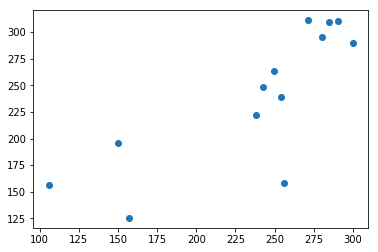

In [17]:
%matplotlib inline
plt.scatter(true, pred)

In [18]:
df = ru.pd_load(PATH+'/hp_df.csv')

In [19]:
df

,Unnamed: 0,filename,valence_pa,atomic_rad_pa_(angstroms),affinity_pa_(eV),ionization_potential_pa_(eV),electronegativity_pa,Crystal_Id,Crystal_ID#,Dom._Pore_(ang.),...,size_17,size_18,size_19,norm_vol_uptake,cat_1,cat_2,cat_3,cat_4,log_pressure,norm_log_pressure
0,0,hypotheticalMOF_5001133_i_0_j_19_k_7_m_2_cat_2...,1.2,1.232,-0.1878,10.236,2.008,-83,-83,4.25,...,-0.146257,-0.107573,-0.070888,-0.827323,0,0,1,0,0.000000,-0.992484
1,1,hypotheticalMOF_5009699_i_0_j_22_k_5_m_9_cat_2...,1.2,1.232,-0.1878,10.236,2.008,35,35,1.75,...,-0.146257,-0.107573,-0.070888,-1.076878,0,0,1,0,0.000000,-0.992484
2,2,hypotheticalMOF_3001230_i_2_j_24_k_23_m_1_cat_...,2.0,1.450,1.2360,7.730,1.900,-114,-114,12.75,...,-0.146257,-0.107573,-0.070888,-1.054830,0,0,1,0,0.000000,-0.992484
3,3,hypotheticalMOF_5022994_i_0_j_27_k_2_m_9_cat_2...,1.2,1.232,-0.1878,10.236,2.008,18,18,6.25,...,-0.146257,-0.107573,-0.070888,-0.940366,0,0,1,0,0.000000,-0.992484
4,4,hypotheticalMOF_5070517_i_2_j_24_k_19_m_2_cat_...,2.0,1.450,1.2360,7.730,1.900,-75,-75,1.75,...,-0.146257,-0.107573,-0.070888,-1.076878,0,1,0,0,0.000000,-0.992484
5,5,hypotheticalMOF_5028838_i_0_j_28_k_19_m_9_cat_...,1.2,1.232,-0.1878,10.236,2.008,-26,-26,6.25,...,-0.146257,-0.107573,-0.070888,-0.969578,0,1,0,0,0.000000,-0.992484
6,6,hypotheticalMOF_5061909_i_2_j_20_k_7_m_12.cif,2.0,1.450,1.2360,7.730,1.900,21,21,9.25,...,-0.146257,-0.107573,-0.070888,1.303599,1,0,0,0,5.513429,1.002509
7,7,hypotheticalMOF_33371_i_2_j_13_k_1_m_2.cif,2.0,1.450,1.2360,7.730,1.900,91,91,10.75,...,-0.146257,-0.107573,-0.070888,1.325678,1,0,0,0,5.513429,1.002509
8,8,hypotheticalMOF_34388_i_2_j_14_k_4_m_7.cif,2.0,1.450,1.2360,7.730,1.900,84,84,4.75,...,-0.146257,-0.107573,-0.070888,0.830107,1,0,0,0,5.513429,1.002509
9,9,hypotheticalMOF_22358_i_1_j_12_k_3_m_4.cif,2.0,1.420,-0.6000,9.390,1.650,86,86,3.25,...,-0.146257,-0.107573,-0.070888,-0.196065,1,0,0,0,5.513429,1.002509


# Scratch

In [4]:
a = np.array([1,3,2])

In [22]:
a.argmax()

1

In [18]:
b = {'a':[1]}

In [19]:
b['a'].append(2)

In [20]:
b

{'a': [1, 2]}

In [3]:
a = pd.DataFrame({'a':['hi','me']}).to_numpy()

In [8]:
np.random.randint(0, len(a), size=, )

array([2, 2])

In [9]:
np.random.choice(a, size=2, replace=False)

array([3, 2])